# Modelling NIQS Hardware

In [1]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from src import *
#np.set_printoptions(threshold=sys.maxsize)

## Choi Form 

### Gradient Descent vs Adam

In [2]:
n = 3
d = 2**n
rank = 2

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
choi_target = ChoiMap(d, rank)
choi_model = ChoiMap(d, rank)

state_target_list = [choi_target.apply_map(state_input) for state_input in state_input_list]

model1 = ModelQuantumMap(model = choi_model,
                         input_list = state_input_list,
                         target_list = state_target_list,
                         cost = state_denstiy_loss,
                         lr = 0.5, 
                         h = 1e-4)

model1.train(num_iter = 1000, 
             use_adam = False)

0: fid: -0.259, c: 0.000
1: fid: -0.510, c: 0.000
2: fid: -0.432, c: 0.000
3: fid: -0.429, c: 0.000
4: fid: -0.485, c: 0.000
5: fid: -0.347, c: 0.000
6: fid: -0.366, c: 0.000
7: fid: -0.491, c: 0.000
8: fid: -0.354, c: 0.000
9: fid: -0.484, c: 0.000
10: fid: -0.326, c: 0.000
11: fid: -0.443, c: 0.000
12: fid: -0.386, c: 0.000
13: fid: -0.367, c: 0.000
14: fid: -0.370, c: 0.000
15: fid: -0.419, c: 0.000
16: fid: -0.248, c: 0.000
17: fid: -0.386, c: 0.000
18: fid: -0.359, c: 0.000
19: fid: -0.410, c: 0.000
20: fid: -0.494, c: 0.000
21: fid: -0.366, c: 0.000
22: fid: -0.294, c: 0.000
23: fid: -0.616, c: 0.000
24: fid: -0.540, c: 0.000
25: fid: -0.582, c: 0.000
26: fid: -0.411, c: 0.000
27: fid: -0.469, c: 0.000
28: fid: -0.239, c: 0.000
29: fid: -0.413, c: 0.000
30: fid: -0.428, c: 0.000
31: fid: -0.465, c: 0.000
32: fid: -0.357, c: 0.000



KeyboardInterrupt: 

### ADAM

In [4]:
n = 3
d = 2**n
rank = 2

input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
choi_target = ChoiMap(d, rank)
choi_model = ChoiMap(d, rank)

target_list = [choi_target.apply_map(input) for input in input_list]

model1 = ModelQuantumMap(q_map = choi_model,
                         cost = state_density_loss,
                         input_list = input_list,
                         target_list = target_list,
                         lr = 0.05, 
                         h = 1e-4)

model1.train(num_iter = 1000, 
             use_adam = True)

0: fid: -0.067, c: 0.000
1: fid: -0.262, c: 0.000
2: fid: -0.169, c: 0.000
3: fid: -0.197, c: 0.000
4: fid: -0.262, c: 0.000
5: fid: -0.101, c: 0.000
6: fid: -0.146, c: 0.000
7: fid: -0.259, c: 0.000
8: fid: -0.144, c: 0.000
9: fid: -0.225, c: 0.000
10: fid: -0.093, c: 0.000
11: fid: -0.270, c: 0.000
12: fid: -0.158, c: 0.000
13: fid: -0.106, c: 0.000
14: fid: -0.147, c: 0.000
15: fid: -0.156, c: 0.000
16: fid: -0.086, c: 0.000
17: fid: -0.172, c: 0.000
18: fid: -0.150, c: 0.000
19: fid: -0.195, c: 0.000
20: fid: -0.260, c: 0.000
21: fid: -0.243, c: 0.000
22: fid: -0.082, c: 0.000
23: fid: -0.484, c: 0.000
24: fid: -0.475, c: 0.000
25: fid: -0.284, c: 0.000
26: fid: -0.221, c: 0.000
27: fid: -0.364, c: 0.000
28: fid: -0.136, c: 0.000
29: fid: -0.319, c: 0.000
30: fid: -0.251, c: 0.000
31: fid: -0.236, c: 0.000
32: fid: -0.158, c: 0.000
33: fid: -0.093, c: 0.000
34: fid: -0.375, c: 0.000
35: fid: -0.139, c: 0.000
36: fid: -0.099, c: 0.000
37: fid: -0.389, c: 0.000
38: fid: -0.229, c: 0.

308: fid: -0.999, c: 0.000
309: fid: -1.000, c: 0.000
310: fid: -0.999, c: 0.000
311: fid: -1.000, c: 0.000
312: fid: -0.999, c: 0.000
313: fid: -0.997, c: 0.000
314: fid: -0.999, c: 0.000
315: fid: -1.000, c: 0.000



KeyboardInterrupt: 

In [ ]:
0: fid: -0.259, c: 0.000
1: fid: -0.512, c: 0.000
2: fid: -0.410, c: 0.000
3: fid: -0.441, c: 0.000
4: fid: -0.515, c: 0.000
5: fid: -0.316, c: 0.000
6: fid: -0.383, c: 0.000

In [ ]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(model1.fid_list)
plt.plot(model2.fid_list)
plt.xlabel("Iteration")
plt.ylabel("Fidelity")
plt.legend(["GD", "ADAM"])
plt.grid()
plt.show()

### Overparameterized Choi Form

In [ ]:
n = 3
d = 2**n

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X_target = generate_ginibre(d**2, 2)
choi_target = generate_choi(X_target)
state_target_list = [apply_map(state_input, choi_target) for state_input in state_input_list]

model3 = ModelQuantumMap(n = 3, 
                         rank = d**2, 
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model3.train(num_iter = 1000, 
             use_adam = True)

### Underparameterized Choi Form

In [ ]:
n = 3
d = 2**n

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X_target = generate_ginibre(d**2, 4)
choi_target = generate_choi(X_target)
state_target_list = [apply_map(state_input, choi_target) for state_input in state_input_list]

model4 = ModelQuantumMap(n = 3, 
                         rank = 2, 
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model4.train(num_iter = 1000, 
             use_adam = True)

### Full Rank Target and Model

In [ ]:
n = 3
d = 2**n

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X_target = generate_ginibre(d**2, d**2)
choi_target = generate_choi(X_target)
state_target_list = [apply_map(state_input, choi_target) for state_input in state_input_list]


model5 = ModelQuantumMap(n = 3, 
                         rank = d**2, 
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model5.train(num_iter = 1000, 
             use_adam = True)

In [ ]:
np.mean((choi_target - choi_model1)**2)

fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(model3.fid_list)
plt.plot(model4.fid_list)
plt.plot(model5.fid_list)
plt.xlabel("Iteration")
plt.ylabel("Fidelity")
plt.legend(["Full Rank Model", "Over-Contrained", "Full Rank Target"])
plt.grid()
plt.show()

## Kraus Form

### Kraus Form with Prior Unitary

In [8]:
n = 3
d = 2**n

input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X)

kraus_target = KrausMap(U, c = 0.7, d = d, rank = 2)

kraus_model = KrausMap(U, c = 0.1, d = d, rank = 2)

target_list = [kraus_target.apply_map(input) for input in input_list]

model1 = ModelQuantumMap(model = kraus_model,
                         cost = state_denstiy_loss,
                         input_list = input_list,
                         target_list = target_list,
                         lr = 0.05, 
                         h = 1e-4)

model1.train(num_iter = 2000, 
             use_adam = True)

0: fid: -0.488, c: 0.105
1: fid: -0.686, c: 0.109
2: fid: -0.664, c: 0.114
3: fid: -0.640, c: 0.119
4: fid: -0.614, c: 0.124
5: fid: -0.555, c: 0.130
6: fid: -0.442, c: 0.136
7: fid: -0.611, c: 0.142
8: fid: -0.580, c: 0.148
9: fid: -0.532, c: 0.154
10: fid: -0.686, c: 0.161
11: fid: -0.617, c: 0.168
12: fid: -0.697, c: 0.175
13: fid: -0.809, c: 0.183
14: fid: -0.627, c: 0.190
15: fid: -0.596, c: 0.198
16: fid: -0.680, c: 0.206
17: fid: -0.692, c: 0.215
18: fid: -0.619, c: 0.223
19: fid: -0.755, c: 0.232
20: fid: -0.665, c: 0.242
21: fid: -0.590, c: 0.251
22: fid: -0.754, c: 0.261
23: fid: -0.636, c: 0.272
24: fid: -0.760, c: 0.282
25: fid: -0.730, c: 0.293
26: fid: -0.733, c: 0.304
27: fid: -0.704, c: 0.316
28: fid: -0.753, c: 0.327
29: fid: -0.797, c: 0.338
30: fid: -0.735, c: 0.350
31: fid: -0.857, c: 0.362
32: fid: -0.707, c: 0.374
33: fid: -0.753, c: 0.386
34: fid: -0.722, c: 0.398
35: fid: -0.775, c: 0.411
36: fid: -0.851, c: 0.423
37: fid: -0.792, c: 0.436
38: fid: -0.836, c: 0.

612: fid: -1.000, c: 0.700
613: fid: -1.000, c: 0.699
614: fid: -1.000, c: 0.699
615: fid: -1.000, c: 0.699
616: fid: -1.000, c: 0.699
617: fid: -1.000, c: 0.699
618: fid: -1.000, c: 0.699
619: fid: -1.000, c: 0.699
620: fid: -1.000, c: 0.699
621: fid: -1.000, c: 0.699
622: fid: -1.000, c: 0.699
623: fid: -1.000, c: 0.699
624: fid: -1.000, c: 0.699
625: fid: -1.000, c: 0.699
626: fid: -1.000, c: 0.699
627: fid: -1.000, c: 0.699
628: fid: -1.000, c: 0.699
629: fid: -1.000, c: 0.699
630: fid: -1.000, c: 0.699
631: fid: -1.000, c: 0.699
632: fid: -1.000, c: 0.699
633: fid: -1.000, c: 0.699
634: fid: -1.000, c: 0.699
635: fid: -1.000, c: 0.699
636: fid: -1.000, c: 0.699
637: fid: -1.000, c: 0.699
638: fid: -1.000, c: 0.699
639: fid: -1.000, c: 0.699
640: fid: -1.000, c: 0.699
641: fid: -1.000, c: 0.699
642: fid: -1.000, c: 0.699
643: fid: -1.000, c: 0.699
644: fid: -1.000, c: 0.700
645: fid: -1.000, c: 0.700
646: fid: -1.000, c: 0.700
647: fid: -1.000, c: 0.700
648: fid: -1.000, c: 0.699
6

1211: fid: -1.000, c: 0.700
1212: fid: -1.000, c: 0.700
1213: fid: -1.000, c: 0.700
1214: fid: -1.000, c: 0.700
1215: fid: -1.000, c: 0.700
1216: fid: -1.000, c: 0.700
1217: fid: -1.000, c: 0.700
1218: fid: -1.000, c: 0.700
1219: fid: -1.000, c: 0.700
1220: fid: -1.000, c: 0.700
1221: fid: -1.000, c: 0.700
1222: fid: -1.000, c: 0.700
1223: fid: -1.000, c: 0.700
1224: fid: -1.000, c: 0.700
1225: fid: -1.000, c: 0.700
1226: fid: -1.000, c: 0.700
1227: fid: -1.000, c: 0.700
1228: fid: -1.000, c: 0.700
1229: fid: -1.000, c: 0.700
1230: fid: -1.000, c: 0.700
1231: fid: -1.000, c: 0.700
1232: fid: -1.000, c: 0.700
1233: fid: -1.000, c: 0.700
1234: fid: -1.000, c: 0.700
1235: fid: -1.000, c: 0.700
1236: fid: -1.000, c: 0.700
1237: fid: -1.000, c: 0.700
1238: fid: -1.000, c: 0.700
1239: fid: -1.000, c: 0.700
1240: fid: -1.000, c: 0.700
1241: fid: -1.000, c: 0.700
1242: fid: -1.000, c: 0.700
1243: fid: -1.000, c: 0.700
1244: fid: -1.000, c: 0.700
1245: fid: -1.000, c: 0.700
1246: fid: -1.000, c

1504: fid: -1.000, c: 0.700
1505: fid: -1.000, c: 0.700
1506: fid: -1.000, c: 0.700
1507: fid: -1.000, c: 0.700
1508: fid: -1.000, c: 0.700
1509: fid: -1.000, c: 0.700
1510: fid: -1.000, c: 0.700
1511: fid: -1.000, c: 0.700
1512: fid: -1.000, c: 0.700
1513: fid: -1.000, c: 0.700
1514: fid: -1.000, c: 0.700
1515: fid: -1.000, c: 0.700
1516: fid: -1.000, c: 0.700
1517: fid: -1.000, c: 0.700
1518: fid: -1.000, c: 0.700
1519: fid: -1.000, c: 0.700
1520: fid: -1.000, c: 0.700
1521: fid: -1.000, c: 0.700
1522: fid: -1.000, c: 0.700
1523: fid: -1.000, c: 0.700
1524: fid: -1.000, c: 0.700
1525: fid: -1.000, c: 0.700
1526: fid: -1.000, c: 0.700
1527: fid: -1.000, c: 0.700
1528: fid: -1.000, c: 0.700
1529: fid: -1.000, c: 0.700
1530: fid: -1.000, c: 0.700
1531: fid: -1.000, c: 0.700
1532: fid: -1.000, c: 0.700
1533: fid: -1.000, c: 0.700
1534: fid: -1.000, c: 0.700
1535: fid: -1.000, c: 0.700
1536: fid: -1.000, c: 0.700
1537: fid: -1.000, c: 0.700
1538: fid: -1.000, c: 0.700
1539: fid: -1.000, c

1798: fid: -1.000, c: 0.700
1799: fid: -1.000, c: 0.700
1800: fid: -1.000, c: 0.700
1801: fid: -1.000, c: 0.700
1802: fid: -1.000, c: 0.700
1803: fid: -1.000, c: 0.700
1804: fid: -1.000, c: 0.700
1805: fid: -1.000, c: 0.700
1806: fid: -1.000, c: 0.700
1807: fid: -1.000, c: 0.700
1808: fid: -1.000, c: 0.700
1809: fid: -1.000, c: 0.700
1810: fid: -1.000, c: 0.700
1811: fid: -1.000, c: 0.700
1812: fid: -1.000, c: 0.700
1813: fid: -1.000, c: 0.700
1814: fid: -1.000, c: 0.700
1815: fid: -1.000, c: 0.700
1816: fid: -1.000, c: 0.700
1817: fid: -1.000, c: 0.700
1818: fid: -1.000, c: 0.700
1819: fid: -1.000, c: 0.700
1820: fid: -1.000, c: 0.700
1821: fid: -1.000, c: 0.700
1822: fid: -1.000, c: 0.700
1823: fid: -1.000, c: 0.700
1824: fid: -1.000, c: 0.700
1825: fid: -1.000, c: 0.700
1826: fid: -1.000, c: 0.700
1827: fid: -1.000, c: 0.700
1828: fid: -1.000, c: 0.700
1829: fid: -1.000, c: 0.700
1830: fid: -1.000, c: 0.700
1831: fid: -1.000, c: 0.700
1832: fid: -1.000, c: 0.700
1833: fid: -1.000, c

### Varying Rank of Model Kraus Form (Constant Rank Target)

#### Make Medium Rank Kraus Target

In [24]:
n = 3
d = 2**n
rank = 5

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X) # Random unitary part
kraus_target = KrausMap(U, 0.5, d, rank)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

#### Models with Varying Rank

In [27]:
trained_models_list = []
for i in range(1, 11):
    kraus_model = KrausMap(U, 0.1, d, i)
    model = ModelQuantumMap(model = kraus_model,
                             state_input_list = state_input_list,
                             state_target_list = state_target_list,
                             lr = 0.025, 
                             h = 1e-4)
    

    model.train(num_iter = 1000, 
                use_adam = True,
                verbose = False)
    trained_models_list.append(model)

### Sparse Input
#### Low Rank

In [2]:
n = 3
d = 2**n
rank = 2

#6^3 = 216 inputs
state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X) # Random unitary part
kraus_target = KrausMap(U, 0.3, d, rank)
choi_target = kraus_to_choi(kraus_target)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

input_target_list = list(zip(state_input_list, state_target_list))
random.shuffle(input_target_list)
state_input_list, state_target_list = zip(*input_target_list)

In [3]:
num_inputs_list = [216, 182, 153, 128, 108, 91, 76, 64, 54, 45, 38, 32, 27, 23, 19, 16, 14, 11, 10]

model_list1 = []
map_fidelity_list1 = []
for num_inputs in num_inputs_list:
    kraus_model = KrausMap(U, 0.1, d, rank)
    model = ModelQuantumMap(model = kraus_model,
                            state_input_list = state_input_list[:num_inputs],
                            state_target_list = state_target_list[:num_inputs],
                            lr = 0.025, 
                            h = 1e-4)
    
    model.train(num_iter = 1000, 
                use_adam = True,
                verbose = False)
    
    choi_model = kraus_to_choi(kraus_model)
    map_fidelity_list1.append(state_fidelity(choi_target, choi_model))
    print(map_fidelity_list1[-1])
    model_list1.append(model)


0.9999013936643407



0.9999835064896315



0.9999780661469398



0.9998446457622567



0.9999671738621458



0.9999554467468498



0.9999859693246185



0.9999174395451892



0.9999861844389453



0.97130496747285



0.9995174686538328



0.9991738028365136



0.9997365040824375



0.9977269698186229



0.9985623215618522



0.9836644426338372



0.9876371209398362



0.9266490575575508



0.927641813417321


#### Medium Rank

In [4]:
n = 3
d = 2**n
rank = 4

#6^3 = 216 inputs
state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X) # Random unitary part
kraus_target = KrausMap(U, 0.3, d, rank)
choi_target = kraus_to_choi(kraus_target)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

input_target_list = list(zip(state_input_list, state_target_list))
random.shuffle(input_target_list)
state_input_list, state_target_list = zip(*input_target_list)

In [5]:
num_inputs_list = [216, 182, 153, 128, 108, 91, 76, 64, 54, 45, 38, 32, 27, 23, 19, 16, 14, 11, 10]

model_list2 = []
map_fidelity_list2 = []
for num_inputs in num_inputs_list:
    kraus_model = KrausMap(U, 0.1, d, rank)
    model = ModelQuantumMap(model = kraus_model,
                            state_input_list = state_input_list[:num_inputs],
                            state_target_list = state_target_list[:num_inputs],
                            lr = 0.025, 
                            h = 1e-4)
    
    model.train(num_iter = 1000, 
                use_adam = True,
                verbose = False)
    
    choi_model = kraus_to_choi(kraus_model)
    map_fidelity_list2.append(state_fidelity(choi_target, choi_model))
    print(map_fidelity_list2[-1])
    model_list2.append(model)


0.9998565206623675



0.9999162525061515



0.9999013397475566



0.9998759403604144



0.9998202411928409



0.9999553452897946



0.9990459453360969



0.9986787761665044



0.9993729923543753



0.9993543073743943



0.9957255682934465



0.9963089233902169



0.9919303943888413



0.9972038876369356



0.8847979619858144



0.9610537212603831



0.8459044851484978



0.8629208914222324



0.7180419406809165


#### High Rank

In [6]:
n = 3
d = 2**n
rank = 8

#6^3 = 216 inputs
state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X) # Random unitary part
kraus_target = KrausMap(U, 0.3, d, rank)
choi_target = kraus_to_choi(kraus_target)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

input_target_list = list(zip(state_input_list, state_target_list))
random.shuffle(input_target_list)
state_input_list, state_target_list = zip(*input_target_list)

In [7]:
num_inputs_list = [216, 182, 153, 128, 108, 91, 76, 64, 54, 45, 38, 32, 27, 23, 19, 16, 14, 11, 10]

model_list3 = []
map_fidelity_list3 = []
for num_inputs in num_inputs_list:
    kraus_model = KrausMap(U, 0.1, d, rank)
    model = ModelQuantumMap(model = kraus_model,
                            state_input_list = state_input_list[:num_inputs],
                            state_target_list = state_target_list[:num_inputs],
                            lr = 0.025, 
                            h = 1e-4)
    
    model.train(num_iter = 1000, 
                use_adam = True,
                verbose = False)
    
    choi_model = kraus_to_choi(kraus_model)
    map_fidelity_list3.append(state_fidelity(choi_target, choi_model))
    print(map_fidelity_list3[-1])
    model_list3.append(model)


0.9973379929834975



0.9952133545468456



0.9953331369910483



0.994242978218583



0.9952697040774853



0.9632249354352782



0.9854052306257306



0.9891496148087953



0.9249122408870116



0.9489879500560617



0.8910442954837736



0.8834309195807175



0.8941611914174872



0.8615056756916677



0.8196856512298651



0.7681109687482754



0.7086752173068909



0.6699012071147044



0.7009876722025834


#### Higher Rank

In [19]:
n = 3
d = 2**n
rank = 16

#6^3 = 216 inputs
state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X) # Random unitary part
kraus_target = KrausMap(U, 0.3, d, rank)
choi_target = kraus_to_choi(kraus_target)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

input_target_list = list(zip(state_input_list, state_target_list))
random.shuffle(input_target_list)
state_input_list, state_target_list = zip(*input_target_list)

In [20]:
num_inputs_list = [216, 182, 153, 128, 108, 91, 76, 64, 54, 45, 38, 32, 27, 23, 19, 16, 14, 11, 10]

model_list4 = []
map_fidelity_list4 = []
for num_inputs in num_inputs_list:
    kraus_model = KrausMap(U, 0.1, d, rank)
    model = ModelQuantumMap(model = kraus_model,
                            state_input_list = state_input_list[:num_inputs],
                            state_target_list = state_target_list[:num_inputs],
                            lr = 0.025, 
                            h = 1e-4)
    
    model.train(num_iter = 1000, 
                use_adam = True,
                verbose = True)
    
    choi_model = kraus_to_choi(kraus_model)
    map_fidelity_list4.append(state_fidelity(choi_target, choi_model))
    print(map_fidelity_list4[-1])
    model_list4.append(model)

0: fid: 0.909, c: 0.102
1: fid: 0.887, c: 0.105
2: fid: 0.922, c: 0.107
3: fid: 0.914, c: 0.109
4: fid: 0.926, c: 0.112
5: fid: 0.889, c: 0.114
6: fid: 0.920, c: 0.117
7: fid: 0.900, c: 0.119
8: fid: 0.926, c: 0.122
9: fid: 0.909, c: 0.125
10: fid: 0.889, c: 0.128
11: fid: 0.897, c: 0.131
12: fid: 0.929, c: 0.133
13: fid: 0.926, c: 0.136
14: fid: 0.898, c: 0.139
15: fid: 0.931, c: 0.142
16: fid: 0.892, c: 0.145
17: fid: 0.884, c: 0.149
18: fid: 0.927, c: 0.152
19: fid: 0.916, c: 0.155
20: fid: 0.935, c: 0.158
21: fid: 0.901, c: 0.162
22: fid: 0.903, c: 0.165
23: fid: 0.939, c: 0.168
24: fid: 0.912, c: 0.172
25: fid: 0.932, c: 0.176
26: fid: 0.898, c: 0.179
27: fid: 0.944, c: 0.183
28: fid: 0.939, c: 0.187
29: fid: 0.924, c: 0.190
30: fid: 0.908, c: 0.194
31: fid: 0.933, c: 0.198
32: fid: 0.940, c: 0.202
33: fid: 0.917, c: 0.206
34: fid: 0.938, c: 0.210
35: fid: 0.949, c: 0.213
36: fid: 0.950, c: 0.217
37: fid: 0.939, c: 0.221
38: fid: 0.955, c: 0.225
39: fid: 0.933, c: 0.229
40: fid: 0

320: fid: 0.986, c: 0.324
321: fid: 0.990, c: 0.324
322: fid: 0.986, c: 0.324
323: fid: 0.985, c: 0.324
324: fid: 0.986, c: 0.324
325: fid: 0.986, c: 0.323
326: fid: 0.977, c: 0.323
327: fid: 0.979, c: 0.322
328: fid: 0.987, c: 0.322
329: fid: 0.977, c: 0.321
330: fid: 0.989, c: 0.320
331: fid: 0.984, c: 0.319
332: fid: 0.989, c: 0.319
333: fid: 0.982, c: 0.318
334: fid: 0.985, c: 0.318
335: fid: 0.986, c: 0.317
336: fid: 0.984, c: 0.317
337: fid: 0.980, c: 0.316
338: fid: 0.986, c: 0.316
339: fid: 0.984, c: 0.316
340: fid: 0.987, c: 0.316
341: fid: 0.987, c: 0.316
342: fid: 0.984, c: 0.316
343: fid: 0.992, c: 0.316
344: fid: 0.989, c: 0.316
345: fid: 0.987, c: 0.316
346: fid: 0.982, c: 0.317
347: fid: 0.986, c: 0.317
348: fid: 0.979, c: 0.317
349: fid: 0.987, c: 0.316
350: fid: 0.990, c: 0.316
351: fid: 0.981, c: 0.316
352: fid: 0.990, c: 0.316
353: fid: 0.986, c: 0.316
354: fid: 0.991, c: 0.316
355: fid: 0.990, c: 0.316
356: fid: 0.987, c: 0.316
357: fid: 0.991, c: 0.316
358: fid: 0.

636: fid: 0.997, c: 0.306
637: fid: 0.994, c: 0.306
638: fid: 0.996, c: 0.306
639: fid: 0.995, c: 0.307
640: fid: 0.996, c: 0.307
641: fid: 0.995, c: 0.308
642: fid: 0.994, c: 0.308
643: fid: 0.994, c: 0.309
644: fid: 0.998, c: 0.309
645: fid: 0.996, c: 0.310
646: fid: 0.996, c: 0.310
647: fid: 0.995, c: 0.310
648: fid: 0.993, c: 0.310
649: fid: 0.997, c: 0.310
650: fid: 0.997, c: 0.310
651: fid: 0.997, c: 0.310
652: fid: 0.996, c: 0.310
653: fid: 0.995, c: 0.310
654: fid: 0.995, c: 0.309
655: fid: 0.995, c: 0.309
656: fid: 0.995, c: 0.309
657: fid: 0.998, c: 0.310
658: fid: 0.998, c: 0.310
659: fid: 0.998, c: 0.311
660: fid: 0.995, c: 0.311
661: fid: 0.995, c: 0.311
662: fid: 0.998, c: 0.312
663: fid: 0.995, c: 0.312
664: fid: 0.995, c: 0.313
665: fid: 0.996, c: 0.313
666: fid: 0.994, c: 0.313
667: fid: 0.994, c: 0.313
668: fid: 0.997, c: 0.313
669: fid: 0.995, c: 0.313
670: fid: 0.996, c: 0.312
671: fid: 0.994, c: 0.312
672: fid: 0.994, c: 0.312
673: fid: 0.995, c: 0.311
674: fid: 0.

952: fid: 0.997, c: 0.307
953: fid: 0.998, c: 0.307
954: fid: 0.999, c: 0.307
955: fid: 0.998, c: 0.306
956: fid: 0.997, c: 0.306
957: fid: 0.997, c: 0.306
958: fid: 0.999, c: 0.306
959: fid: 0.998, c: 0.305
960: fid: 0.998, c: 0.305
961: fid: 0.997, c: 0.305
962: fid: 0.998, c: 0.305
963: fid: 0.998, c: 0.305
964: fid: 0.998, c: 0.305
965: fid: 0.998, c: 0.305
966: fid: 0.999, c: 0.305
967: fid: 0.996, c: 0.305
968: fid: 0.997, c: 0.305
969: fid: 0.998, c: 0.305
970: fid: 0.999, c: 0.305
971: fid: 0.998, c: 0.304
972: fid: 0.998, c: 0.304
973: fid: 0.998, c: 0.304
974: fid: 0.999, c: 0.304
975: fid: 0.998, c: 0.304
976: fid: 0.997, c: 0.304
977: fid: 0.998, c: 0.304
978: fid: 0.999, c: 0.304
979: fid: 0.998, c: 0.304
980: fid: 0.998, c: 0.304
981: fid: 0.998, c: 0.305
982: fid: 0.999, c: 0.305
983: fid: 0.999, c: 0.305
984: fid: 0.997, c: 0.305
985: fid: 0.997, c: 0.305
986: fid: 0.999, c: 0.305
987: fid: 0.999, c: 0.305
988: fid: 0.998, c: 0.305
989: fid: 0.995, c: 0.305
990: fid: 0.

0: fid: 0.903, c: 0.102
1: fid: 0.857, c: 0.105
2: fid: 0.926, c: 0.107
3: fid: 0.899, c: 0.109
4: fid: 0.899, c: 0.112
5: fid: 0.897, c: 0.114
6: fid: 0.898, c: 0.117
7: fid: 0.913, c: 0.119
8: fid: 0.927, c: 0.122
9: fid: 0.886, c: 0.124
10: fid: 0.905, c: 0.127
11: fid: 0.894, c: 0.130
12: fid: 0.926, c: 0.133
13: fid: 0.908, c: 0.135
14: fid: 0.895, c: 0.138
15: fid: 0.921, c: 0.141
16: fid: 0.920, c: 0.144
17: fid: 0.906, c: 0.147
18: fid: 0.888, c: 0.150
19: fid: 0.926, c: 0.153
20: fid: 0.923, c: 0.157
21: fid: 0.907, c: 0.160
22: fid: 0.912, c: 0.163
23: fid: 0.963, c: 0.167
24: fid: 0.904, c: 0.170
25: fid: 0.916, c: 0.173
26: fid: 0.920, c: 0.177
27: fid: 0.937, c: 0.180
28: fid: 0.969, c: 0.184
29: fid: 0.943, c: 0.187
30: fid: 0.926, c: 0.191
31: fid: 0.945, c: 0.194
32: fid: 0.926, c: 0.198
33: fid: 0.946, c: 0.202
34: fid: 0.940, c: 0.205
35: fid: 0.939, c: 0.209
36: fid: 0.925, c: 0.213
37: fid: 0.940, c: 0.217
38: fid: 0.920, c: 0.221
39: fid: 0.920, c: 0.224
40: fid: 0

320: fid: 0.983, c: 0.322
321: fid: 0.987, c: 0.322
322: fid: 0.983, c: 0.322
323: fid: 0.982, c: 0.321
324: fid: 0.987, c: 0.321
325: fid: 0.990, c: 0.320
326: fid: 0.989, c: 0.320
327: fid: 0.973, c: 0.319
328: fid: 0.985, c: 0.319
329: fid: 0.987, c: 0.318
330: fid: 0.988, c: 0.318
331: fid: 0.979, c: 0.317
332: fid: 0.991, c: 0.317
333: fid: 0.987, c: 0.316
334: fid: 0.988, c: 0.316
335: fid: 0.992, c: 0.315
336: fid: 0.992, c: 0.315
337: fid: 0.987, c: 0.314
338: fid: 0.990, c: 0.313
339: fid: 0.987, c: 0.312
340: fid: 0.990, c: 0.311
341: fid: 0.982, c: 0.311
342: fid: 0.986, c: 0.311
343: fid: 0.986, c: 0.310
344: fid: 0.988, c: 0.310
345: fid: 0.980, c: 0.310
346: fid: 0.990, c: 0.310
347: fid: 0.987, c: 0.310
348: fid: 0.994, c: 0.310
349: fid: 0.977, c: 0.310
350: fid: 0.993, c: 0.310
351: fid: 0.981, c: 0.310
352: fid: 0.987, c: 0.310
353: fid: 0.980, c: 0.310
354: fid: 0.974, c: 0.310
355: fid: 0.979, c: 0.311
356: fid: 0.990, c: 0.311
357: fid: 0.987, c: 0.312
358: fid: 0.

636: fid: 0.996, c: 0.314
637: fid: 0.992, c: 0.314
638: fid: 0.996, c: 0.314
639: fid: 0.994, c: 0.314
640: fid: 0.993, c: 0.314
641: fid: 0.993, c: 0.314
642: fid: 0.994, c: 0.314
643: fid: 0.993, c: 0.314
644: fid: 0.995, c: 0.313
645: fid: 0.994, c: 0.313
646: fid: 0.994, c: 0.312
647: fid: 0.999, c: 0.312
648: fid: 0.997, c: 0.311
649: fid: 0.996, c: 0.311
650: fid: 0.995, c: 0.311
651: fid: 0.995, c: 0.310
652: fid: 0.996, c: 0.310
653: fid: 0.995, c: 0.310
654: fid: 0.995, c: 0.310
655: fid: 0.996, c: 0.311
656: fid: 0.996, c: 0.311
657: fid: 0.997, c: 0.311
658: fid: 0.994, c: 0.311
659: fid: 0.994, c: 0.311
660: fid: 0.995, c: 0.311
661: fid: 0.994, c: 0.312
662: fid: 0.996, c: 0.312
663: fid: 0.994, c: 0.312
664: fid: 0.993, c: 0.312
665: fid: 0.994, c: 0.312
666: fid: 0.992, c: 0.312
667: fid: 0.998, c: 0.312
668: fid: 0.997, c: 0.312
669: fid: 0.995, c: 0.312
670: fid: 0.992, c: 0.312
671: fid: 0.995, c: 0.312
672: fid: 0.993, c: 0.312
673: fid: 0.997, c: 0.312
674: fid: 0.

952: fid: 0.999, c: 0.306
953: fid: 0.997, c: 0.306
954: fid: 0.999, c: 0.306
955: fid: 0.998, c: 0.306
956: fid: 0.998, c: 0.306
957: fid: 0.999, c: 0.306
958: fid: 0.998, c: 0.306
959: fid: 0.996, c: 0.306
960: fid: 0.997, c: 0.306
961: fid: 0.998, c: 0.305
962: fid: 0.998, c: 0.305
963: fid: 0.998, c: 0.305
964: fid: 0.998, c: 0.305
965: fid: 0.999, c: 0.304
966: fid: 0.998, c: 0.304
967: fid: 0.998, c: 0.304
968: fid: 0.999, c: 0.304
969: fid: 0.997, c: 0.304
970: fid: 0.999, c: 0.304
971: fid: 0.997, c: 0.304
972: fid: 0.998, c: 0.305
973: fid: 0.999, c: 0.305
974: fid: 0.998, c: 0.305
975: fid: 0.998, c: 0.305
976: fid: 0.997, c: 0.305
977: fid: 0.996, c: 0.305
978: fid: 0.998, c: 0.305
979: fid: 0.998, c: 0.305
980: fid: 0.996, c: 0.304
981: fid: 0.998, c: 0.304
982: fid: 0.999, c: 0.304
983: fid: 0.999, c: 0.305
984: fid: 0.998, c: 0.305
985: fid: 0.999, c: 0.305
986: fid: 0.998, c: 0.305
987: fid: 0.999, c: 0.305
988: fid: 0.997, c: 0.305
989: fid: 0.998, c: 0.305
990: fid: 0.

0: fid: 0.897, c: 0.102
1: fid: 0.907, c: 0.105
2: fid: 0.911, c: 0.107
3: fid: 0.919, c: 0.109
4: fid: 0.896, c: 0.112
5: fid: 0.931, c: 0.114
6: fid: 0.937, c: 0.117
7: fid: 0.895, c: 0.119
8: fid: 0.926, c: 0.122
9: fid: 0.902, c: 0.124
10: fid: 0.927, c: 0.127
11: fid: 0.894, c: 0.130
12: fid: 0.885, c: 0.132
13: fid: 0.913, c: 0.135
14: fid: 0.918, c: 0.138
15: fid: 0.908, c: 0.141
16: fid: 0.925, c: 0.144
17: fid: 0.910, c: 0.148
18: fid: 0.902, c: 0.151
19: fid: 0.908, c: 0.154
20: fid: 0.938, c: 0.157
21: fid: 0.912, c: 0.161
22: fid: 0.900, c: 0.164
23: fid: 0.920, c: 0.168
24: fid: 0.874, c: 0.171
25: fid: 0.935, c: 0.175
26: fid: 0.940, c: 0.178
27: fid: 0.938, c: 0.182
28: fid: 0.935, c: 0.186
29: fid: 0.920, c: 0.189
30: fid: 0.910, c: 0.193
31: fid: 0.913, c: 0.197
32: fid: 0.930, c: 0.201
33: fid: 0.929, c: 0.205
34: fid: 0.931, c: 0.209
35: fid: 0.916, c: 0.213
36: fid: 0.911, c: 0.217
37: fid: 0.914, c: 0.221
38: fid: 0.941, c: 0.225
39: fid: 0.944, c: 0.229
40: fid: 0

320: fid: 0.981, c: 0.318
321: fid: 0.988, c: 0.318
322: fid: 0.975, c: 0.318
323: fid: 0.987, c: 0.318
324: fid: 0.992, c: 0.318
325: fid: 0.991, c: 0.318
326: fid: 0.986, c: 0.318
327: fid: 0.981, c: 0.318
328: fid: 0.992, c: 0.318
329: fid: 0.985, c: 0.317
330: fid: 0.991, c: 0.317
331: fid: 0.987, c: 0.316
332: fid: 0.988, c: 0.316
333: fid: 0.988, c: 0.316
334: fid: 0.984, c: 0.316
335: fid: 0.987, c: 0.316
336: fid: 0.985, c: 0.316
337: fid: 0.985, c: 0.316
338: fid: 0.974, c: 0.316
339: fid: 0.988, c: 0.317
340: fid: 0.988, c: 0.317
341: fid: 0.988, c: 0.316
342: fid: 0.992, c: 0.316
343: fid: 0.992, c: 0.316
344: fid: 0.985, c: 0.316
345: fid: 0.986, c: 0.316
346: fid: 0.994, c: 0.315
347: fid: 0.983, c: 0.315
348: fid: 0.981, c: 0.315
349: fid: 0.991, c: 0.315
350: fid: 0.978, c: 0.315
351: fid: 0.984, c: 0.315
352: fid: 0.985, c: 0.315
353: fid: 0.994, c: 0.315
354: fid: 0.981, c: 0.315
355: fid: 0.990, c: 0.315
356: fid: 0.989, c: 0.315
357: fid: 0.992, c: 0.315
358: fid: 0.

636: fid: 0.996, c: 0.311
637: fid: 0.995, c: 0.312
638: fid: 0.997, c: 0.312
639: fid: 0.991, c: 0.312
640: fid: 0.992, c: 0.313
641: fid: 0.996, c: 0.313
642: fid: 0.992, c: 0.313
643: fid: 0.994, c: 0.313
644: fid: 0.997, c: 0.313
645: fid: 0.990, c: 0.313
646: fid: 0.996, c: 0.313
647: fid: 0.994, c: 0.313
648: fid: 0.995, c: 0.313
649: fid: 0.996, c: 0.313
650: fid: 0.995, c: 0.313
651: fid: 0.993, c: 0.313
652: fid: 0.993, c: 0.313
653: fid: 0.994, c: 0.313
654: fid: 0.995, c: 0.313
655: fid: 0.996, c: 0.312
656: fid: 0.996, c: 0.312
657: fid: 0.993, c: 0.311
658: fid: 0.994, c: 0.310
659: fid: 0.994, c: 0.310
660: fid: 0.997, c: 0.309
661: fid: 0.995, c: 0.309
662: fid: 0.991, c: 0.309
663: fid: 0.994, c: 0.309
664: fid: 0.994, c: 0.308
665: fid: 0.997, c: 0.308
666: fid: 0.996, c: 0.307
667: fid: 0.994, c: 0.307
668: fid: 0.995, c: 0.306
669: fid: 0.995, c: 0.306
670: fid: 0.996, c: 0.305
671: fid: 0.994, c: 0.305
672: fid: 0.995, c: 0.304
673: fid: 0.991, c: 0.304
674: fid: 0.

952: fid: 0.996, c: 0.308
953: fid: 0.998, c: 0.307
954: fid: 0.999, c: 0.307
955: fid: 0.999, c: 0.306
956: fid: 0.998, c: 0.306
957: fid: 0.998, c: 0.305
958: fid: 0.998, c: 0.304
959: fid: 0.999, c: 0.303
960: fid: 0.999, c: 0.303
961: fid: 0.999, c: 0.302
962: fid: 0.996, c: 0.301
963: fid: 0.997, c: 0.301
964: fid: 0.997, c: 0.300
965: fid: 0.998, c: 0.300
966: fid: 0.998, c: 0.300
967: fid: 0.998, c: 0.300
968: fid: 0.999, c: 0.300
969: fid: 0.998, c: 0.300
970: fid: 0.998, c: 0.301
971: fid: 0.998, c: 0.301
972: fid: 0.996, c: 0.301
973: fid: 0.997, c: 0.302
974: fid: 0.999, c: 0.302
975: fid: 0.998, c: 0.303
976: fid: 0.999, c: 0.303
977: fid: 0.999, c: 0.303
978: fid: 0.998, c: 0.304
979: fid: 0.998, c: 0.304
980: fid: 0.998, c: 0.304
981: fid: 0.998, c: 0.304
982: fid: 0.999, c: 0.304
983: fid: 0.999, c: 0.304
984: fid: 0.998, c: 0.304
985: fid: 0.999, c: 0.304
986: fid: 0.998, c: 0.303
987: fid: 0.999, c: 0.303
988: fid: 0.998, c: 0.303
989: fid: 0.999, c: 0.303
990: fid: 0.

0: fid: 0.876, c: 0.102
1: fid: 0.926, c: 0.105
2: fid: 0.902, c: 0.107
3: fid: 0.909, c: 0.109
4: fid: 0.890, c: 0.111
5: fid: 0.916, c: 0.114
6: fid: 0.921, c: 0.116
7: fid: 0.910, c: 0.119
8: fid: 0.878, c: 0.121
9: fid: 0.914, c: 0.124
10: fid: 0.921, c: 0.126
11: fid: 0.914, c: 0.129
12: fid: 0.918, c: 0.132
13: fid: 0.926, c: 0.135
14: fid: 0.935, c: 0.138
15: fid: 0.902, c: 0.140
16: fid: 0.914, c: 0.143
17: fid: 0.922, c: 0.146
18: fid: 0.939, c: 0.150
19: fid: 0.924, c: 0.153
20: fid: 0.904, c: 0.156
21: fid: 0.912, c: 0.159
22: fid: 0.957, c: 0.162
23: fid: 0.924, c: 0.166
24: fid: 0.924, c: 0.169
25: fid: 0.946, c: 0.173
26: fid: 0.959, c: 0.176
27: fid: 0.932, c: 0.179
28: fid: 0.927, c: 0.183
29: fid: 0.916, c: 0.186
30: fid: 0.935, c: 0.190
31: fid: 0.912, c: 0.193
32: fid: 0.939, c: 0.197
33: fid: 0.953, c: 0.201
34: fid: 0.922, c: 0.205
35: fid: 0.937, c: 0.209
36: fid: 0.941, c: 0.213
37: fid: 0.946, c: 0.217
38: fid: 0.951, c: 0.221
39: fid: 0.931, c: 0.225
40: fid: 0

320: fid: 0.990, c: 0.313
321: fid: 0.986, c: 0.313
322: fid: 0.990, c: 0.313
323: fid: 0.993, c: 0.313
324: fid: 0.986, c: 0.313
325: fid: 0.989, c: 0.313
326: fid: 0.984, c: 0.313
327: fid: 0.991, c: 0.313
328: fid: 0.986, c: 0.313
329: fid: 0.987, c: 0.313
330: fid: 0.992, c: 0.313
331: fid: 0.992, c: 0.312
332: fid: 0.993, c: 0.312
333: fid: 0.990, c: 0.312
334: fid: 0.986, c: 0.312
335: fid: 0.989, c: 0.312
336: fid: 0.984, c: 0.312
337: fid: 0.991, c: 0.311
338: fid: 0.984, c: 0.311
339: fid: 0.991, c: 0.310
340: fid: 0.984, c: 0.309
341: fid: 0.989, c: 0.309
342: fid: 0.981, c: 0.309
343: fid: 0.992, c: 0.308
344: fid: 0.986, c: 0.307
345: fid: 0.992, c: 0.307
346: fid: 0.983, c: 0.306
347: fid: 0.976, c: 0.306
348: fid: 0.991, c: 0.305
349: fid: 0.980, c: 0.305
350: fid: 0.979, c: 0.306
351: fid: 0.990, c: 0.306
352: fid: 0.987, c: 0.306
353: fid: 0.991, c: 0.307
354: fid: 0.986, c: 0.308
355: fid: 0.993, c: 0.308
356: fid: 0.995, c: 0.309
357: fid: 0.987, c: 0.309
358: fid: 0.

636: fid: 0.996, c: 0.308
637: fid: 0.997, c: 0.308
638: fid: 0.997, c: 0.308
639: fid: 0.995, c: 0.308
640: fid: 0.993, c: 0.309
641: fid: 0.995, c: 0.309
642: fid: 0.997, c: 0.309
643: fid: 0.992, c: 0.310
644: fid: 0.994, c: 0.310
645: fid: 0.998, c: 0.310
646: fid: 0.996, c: 0.311
647: fid: 0.996, c: 0.311
648: fid: 0.996, c: 0.311
649: fid: 0.996, c: 0.311
650: fid: 0.995, c: 0.311
651: fid: 0.994, c: 0.311
652: fid: 0.994, c: 0.311
653: fid: 0.997, c: 0.311
654: fid: 0.996, c: 0.311
655: fid: 0.997, c: 0.311
656: fid: 0.992, c: 0.311
657: fid: 0.994, c: 0.311
658: fid: 0.998, c: 0.311
659: fid: 0.993, c: 0.311
660: fid: 0.996, c: 0.310
661: fid: 0.996, c: 0.310
662: fid: 0.998, c: 0.309
663: fid: 0.997, c: 0.308
664: fid: 0.997, c: 0.308
665: fid: 0.997, c: 0.307
666: fid: 0.997, c: 0.306
667: fid: 0.996, c: 0.306
668: fid: 0.995, c: 0.305
669: fid: 0.998, c: 0.305
670: fid: 0.998, c: 0.304
671: fid: 0.996, c: 0.304
672: fid: 0.998, c: 0.303
673: fid: 0.995, c: 0.303
674: fid: 0.

952: fid: 0.998, c: 0.305
953: fid: 0.999, c: 0.305
954: fid: 0.998, c: 0.305
955: fid: 0.998, c: 0.305
956: fid: 0.998, c: 0.305
957: fid: 0.999, c: 0.305
958: fid: 0.999, c: 0.305
959: fid: 0.999, c: 0.304
960: fid: 0.999, c: 0.304
961: fid: 0.997, c: 0.304
962: fid: 0.999, c: 0.303
963: fid: 0.996, c: 0.302
964: fid: 0.997, c: 0.302
965: fid: 0.999, c: 0.302
966: fid: 0.998, c: 0.302
967: fid: 0.999, c: 0.301
968: fid: 0.999, c: 0.301
969: fid: 0.998, c: 0.301
970: fid: 0.999, c: 0.301
971: fid: 0.999, c: 0.301
972: fid: 0.998, c: 0.301
973: fid: 0.998, c: 0.302
974: fid: 0.999, c: 0.302
975: fid: 0.999, c: 0.303
976: fid: 0.998, c: 0.303
977: fid: 0.996, c: 0.303
978: fid: 0.998, c: 0.304
979: fid: 0.999, c: 0.304
980: fid: 0.999, c: 0.304
981: fid: 0.999, c: 0.304
982: fid: 0.998, c: 0.304
983: fid: 0.997, c: 0.304
984: fid: 0.998, c: 0.304
985: fid: 0.999, c: 0.304
986: fid: 0.999, c: 0.304
987: fid: 0.998, c: 0.304
988: fid: 0.998, c: 0.304
989: fid: 0.999, c: 0.304
990: fid: 0.

0: fid: 0.876, c: 0.102
1: fid: 0.922, c: 0.105
2: fid: 0.886, c: 0.107
3: fid: 0.887, c: 0.109
4: fid: 0.871, c: 0.112
5: fid: 0.865, c: 0.114
6: fid: 0.900, c: 0.117
7: fid: 0.886, c: 0.120
8: fid: 0.912, c: 0.122
9: fid: 0.847, c: 0.125
10: fid: 0.907, c: 0.128
11: fid: 0.927, c: 0.131
12: fid: 0.930, c: 0.133
13: fid: 0.933, c: 0.136
14: fid: 0.909, c: 0.139
15: fid: 0.915, c: 0.142
16: fid: 0.917, c: 0.145
17: fid: 0.919, c: 0.148
18: fid: 0.910, c: 0.151
19: fid: 0.903, c: 0.154
20: fid: 0.912, c: 0.157
21: fid: 0.898, c: 0.161
22: fid: 0.938, c: 0.164
23: fid: 0.926, c: 0.167
24: fid: 0.929, c: 0.171
25: fid: 0.919, c: 0.174
26: fid: 0.931, c: 0.177
27: fid: 0.898, c: 0.181
28: fid: 0.943, c: 0.184
29: fid: 0.954, c: 0.188
30: fid: 0.961, c: 0.191
31: fid: 0.918, c: 0.194
32: fid: 0.935, c: 0.198
33: fid: 0.921, c: 0.201
34: fid: 0.960, c: 0.205
35: fid: 0.927, c: 0.208
36: fid: 0.924, c: 0.212
37: fid: 0.915, c: 0.216
38: fid: 0.949, c: 0.219
39: fid: 0.927, c: 0.223
40: fid: 0

320: fid: 0.994, c: 0.314
321: fid: 0.998, c: 0.314
322: fid: 0.983, c: 0.314
323: fid: 0.983, c: 0.314
324: fid: 0.973, c: 0.314
325: fid: 0.974, c: 0.315
326: fid: 0.975, c: 0.316
327: fid: 0.987, c: 0.317
328: fid: 0.992, c: 0.318
329: fid: 0.987, c: 0.319
330: fid: 0.979, c: 0.320
331: fid: 0.984, c: 0.321
332: fid: 0.987, c: 0.322
333: fid: 0.981, c: 0.322
334: fid: 0.984, c: 0.323
335: fid: 0.987, c: 0.323
336: fid: 0.991, c: 0.323
337: fid: 0.990, c: 0.322
338: fid: 0.988, c: 0.322
339: fid: 0.986, c: 0.322
340: fid: 0.983, c: 0.321
341: fid: 0.992, c: 0.321
342: fid: 0.985, c: 0.321
343: fid: 0.983, c: 0.321
344: fid: 0.974, c: 0.320
345: fid: 0.993, c: 0.320
346: fid: 0.988, c: 0.319
347: fid: 0.979, c: 0.319
348: fid: 0.994, c: 0.319
349: fid: 0.992, c: 0.318
350: fid: 0.981, c: 0.318
351: fid: 0.991, c: 0.317
352: fid: 0.982, c: 0.316
353: fid: 0.984, c: 0.315
354: fid: 0.991, c: 0.315
355: fid: 0.989, c: 0.314
356: fid: 0.994, c: 0.314
357: fid: 0.989, c: 0.314
358: fid: 0.

636: fid: 0.995, c: 0.313
637: fid: 0.995, c: 0.312
638: fid: 0.995, c: 0.312
639: fid: 0.997, c: 0.311
640: fid: 0.997, c: 0.311
641: fid: 0.995, c: 0.311
642: fid: 0.994, c: 0.311
643: fid: 0.993, c: 0.312
644: fid: 0.991, c: 0.312
645: fid: 0.994, c: 0.313
646: fid: 0.997, c: 0.313
647: fid: 0.996, c: 0.313
648: fid: 0.996, c: 0.313
649: fid: 0.997, c: 0.313
650: fid: 0.995, c: 0.312
651: fid: 0.995, c: 0.311
652: fid: 0.998, c: 0.311
653: fid: 0.998, c: 0.310
654: fid: 0.996, c: 0.310
655: fid: 0.997, c: 0.309
656: fid: 0.995, c: 0.309
657: fid: 0.996, c: 0.309
658: fid: 0.995, c: 0.309
659: fid: 0.996, c: 0.309
660: fid: 0.994, c: 0.309
661: fid: 0.997, c: 0.309
662: fid: 0.997, c: 0.308
663: fid: 0.997, c: 0.308
664: fid: 0.993, c: 0.308
665: fid: 0.995, c: 0.307
666: fid: 0.992, c: 0.307
667: fid: 0.998, c: 0.306
668: fid: 0.992, c: 0.306
669: fid: 0.993, c: 0.306
670: fid: 0.998, c: 0.307
671: fid: 0.997, c: 0.307
672: fid: 0.997, c: 0.308
673: fid: 0.998, c: 0.308
674: fid: 0.

952: fid: 0.997, c: 0.303
953: fid: 0.998, c: 0.303
954: fid: 0.999, c: 0.304
955: fid: 0.999, c: 0.304
956: fid: 0.999, c: 0.305
957: fid: 0.997, c: 0.305
958: fid: 0.998, c: 0.306
959: fid: 0.998, c: 0.306
960: fid: 0.997, c: 0.307
961: fid: 0.999, c: 0.307
962: fid: 0.997, c: 0.307
963: fid: 0.997, c: 0.308
964: fid: 0.998, c: 0.308
965: fid: 0.998, c: 0.308
966: fid: 0.997, c: 0.308
967: fid: 0.998, c: 0.309
968: fid: 0.999, c: 0.309
969: fid: 0.999, c: 0.309
970: fid: 0.998, c: 0.309
971: fid: 0.998, c: 0.308
972: fid: 0.999, c: 0.308
973: fid: 0.999, c: 0.307
974: fid: 0.999, c: 0.307
975: fid: 0.997, c: 0.306
976: fid: 0.996, c: 0.306
977: fid: 0.998, c: 0.305
978: fid: 0.999, c: 0.305
979: fid: 0.997, c: 0.304
980: fid: 0.999, c: 0.304
981: fid: 0.998, c: 0.304
982: fid: 0.998, c: 0.304
983: fid: 0.999, c: 0.304
984: fid: 0.998, c: 0.304
985: fid: 0.998, c: 0.304
986: fid: 0.999, c: 0.304
987: fid: 0.997, c: 0.304
988: fid: 0.998, c: 0.304
989: fid: 0.998, c: 0.305
990: fid: 0.

0: fid: 0.889, c: 0.102
1: fid: 0.883, c: 0.105
2: fid: 0.873, c: 0.107
3: fid: 0.875, c: 0.109
4: fid: 0.905, c: 0.112
5: fid: 0.916, c: 0.114
6: fid: 0.899, c: 0.117
7: fid: 0.866, c: 0.119
8: fid: 0.880, c: 0.122
9: fid: 0.907, c: 0.124
10: fid: 0.887, c: 0.127
11: fid: 0.908, c: 0.130
12: fid: 0.918, c: 0.133
13: fid: 0.897, c: 0.135
14: fid: 0.896, c: 0.138
15: fid: 0.899, c: 0.141
16: fid: 0.902, c: 0.144
17: fid: 0.912, c: 0.147
18: fid: 0.926, c: 0.150
19: fid: 0.912, c: 0.153
20: fid: 0.932, c: 0.156
21: fid: 0.935, c: 0.159
22: fid: 0.922, c: 0.163
23: fid: 0.928, c: 0.166
24: fid: 0.917, c: 0.169
25: fid: 0.917, c: 0.172
26: fid: 0.903, c: 0.175
27: fid: 0.916, c: 0.179
28: fid: 0.932, c: 0.182
29: fid: 0.933, c: 0.185
30: fid: 0.933, c: 0.188
31: fid: 0.948, c: 0.191
32: fid: 0.938, c: 0.195
33: fid: 0.930, c: 0.198
34: fid: 0.946, c: 0.201
35: fid: 0.947, c: 0.205
36: fid: 0.937, c: 0.208
37: fid: 0.957, c: 0.211
38: fid: 0.943, c: 0.214
39: fid: 0.930, c: 0.218
40: fid: 0

320: fid: 0.990, c: 0.313
321: fid: 0.991, c: 0.313
322: fid: 0.986, c: 0.312
323: fid: 0.986, c: 0.312
324: fid: 0.997, c: 0.312
325: fid: 0.995, c: 0.311
326: fid: 0.991, c: 0.311
327: fid: 0.990, c: 0.310
328: fid: 0.987, c: 0.310
329: fid: 0.987, c: 0.309
330: fid: 0.983, c: 0.309
331: fid: 0.989, c: 0.308
332: fid: 0.984, c: 0.308
333: fid: 0.988, c: 0.307
334: fid: 0.989, c: 0.307
335: fid: 0.977, c: 0.307
336: fid: 0.992, c: 0.307
337: fid: 0.993, c: 0.306
338: fid: 0.987, c: 0.306
339: fid: 0.993, c: 0.306
340: fid: 0.989, c: 0.306
341: fid: 0.980, c: 0.306
342: fid: 0.989, c: 0.306
343: fid: 0.991, c: 0.306
344: fid: 0.992, c: 0.306
345: fid: 0.990, c: 0.306
346: fid: 0.981, c: 0.307
347: fid: 0.995, c: 0.307
348: fid: 0.986, c: 0.307
349: fid: 0.991, c: 0.307
350: fid: 0.991, c: 0.307
351: fid: 0.993, c: 0.307
352: fid: 0.983, c: 0.308
353: fid: 0.988, c: 0.308
354: fid: 0.984, c: 0.309
355: fid: 0.991, c: 0.310
356: fid: 0.983, c: 0.310
357: fid: 0.986, c: 0.310
358: fid: 0.

636: fid: 0.997, c: 0.305
637: fid: 0.996, c: 0.305
638: fid: 0.996, c: 0.305
639: fid: 0.998, c: 0.305
640: fid: 0.998, c: 0.305
641: fid: 0.997, c: 0.305
642: fid: 0.994, c: 0.304
643: fid: 0.995, c: 0.304
644: fid: 0.990, c: 0.304
645: fid: 0.997, c: 0.304
646: fid: 0.998, c: 0.304
647: fid: 0.995, c: 0.305
648: fid: 0.994, c: 0.305
649: fid: 0.996, c: 0.305
650: fid: 0.999, c: 0.305
651: fid: 0.993, c: 0.305
652: fid: 0.997, c: 0.306
653: fid: 0.992, c: 0.306
654: fid: 0.994, c: 0.306
655: fid: 0.987, c: 0.306
656: fid: 0.992, c: 0.306
657: fid: 0.994, c: 0.307
658: fid: 0.997, c: 0.307
659: fid: 0.997, c: 0.307
660: fid: 0.999, c: 0.307
661: fid: 0.998, c: 0.307
662: fid: 0.994, c: 0.307
663: fid: 0.996, c: 0.307
664: fid: 0.995, c: 0.307
665: fid: 0.992, c: 0.307
666: fid: 0.996, c: 0.307
667: fid: 0.994, c: 0.307
668: fid: 0.994, c: 0.307
669: fid: 0.994, c: 0.306
670: fid: 0.992, c: 0.306
671: fid: 0.990, c: 0.305
672: fid: 0.998, c: 0.305
673: fid: 0.999, c: 0.304
674: fid: 0.

952: fid: 0.998, c: 0.302
953: fid: 0.999, c: 0.302
954: fid: 0.997, c: 0.302
955: fid: 0.999, c: 0.303
956: fid: 0.999, c: 0.303
957: fid: 0.999, c: 0.303
958: fid: 0.999, c: 0.304
959: fid: 0.999, c: 0.304
960: fid: 0.997, c: 0.305
961: fid: 0.998, c: 0.305
962: fid: 0.998, c: 0.305
963: fid: 0.997, c: 0.305
964: fid: 0.999, c: 0.305
965: fid: 0.999, c: 0.305
966: fid: 0.997, c: 0.304
967: fid: 0.995, c: 0.304
968: fid: 0.999, c: 0.304
969: fid: 0.997, c: 0.303
970: fid: 0.998, c: 0.303
971: fid: 0.996, c: 0.303
972: fid: 0.998, c: 0.302
973: fid: 0.998, c: 0.301
974: fid: 0.998, c: 0.301
975: fid: 0.999, c: 0.300
976: fid: 0.999, c: 0.300
977: fid: 0.997, c: 0.300
978: fid: 0.997, c: 0.301
979: fid: 0.997, c: 0.301
980: fid: 0.998, c: 0.302
981: fid: 0.999, c: 0.302
982: fid: 0.998, c: 0.303
983: fid: 0.998, c: 0.303
984: fid: 0.996, c: 0.304
985: fid: 0.999, c: 0.304
986: fid: 0.999, c: 0.305
987: fid: 0.996, c: 0.305
988: fid: 0.999, c: 0.305
989: fid: 0.999, c: 0.305
990: fid: 0.

0: fid: 0.897, c: 0.102
1: fid: 0.924, c: 0.105
2: fid: 0.883, c: 0.107
3: fid: 0.936, c: 0.109
4: fid: 0.926, c: 0.112
5: fid: 0.882, c: 0.114
6: fid: 0.883, c: 0.117
7: fid: 0.899, c: 0.120
8: fid: 0.909, c: 0.122
9: fid: 0.869, c: 0.125
10: fid: 0.904, c: 0.128
11: fid: 0.930, c: 0.131
12: fid: 0.872, c: 0.133
13: fid: 0.907, c: 0.136
14: fid: 0.949, c: 0.139
15: fid: 0.942, c: 0.142
16: fid: 0.937, c: 0.145
17: fid: 0.938, c: 0.148
18: fid: 0.907, c: 0.151
19: fid: 0.923, c: 0.155
20: fid: 0.937, c: 0.158
21: fid: 0.919, c: 0.161
22: fid: 0.925, c: 0.164
23: fid: 0.939, c: 0.168
24: fid: 0.928, c: 0.171
25: fid: 0.951, c: 0.174
26: fid: 0.963, c: 0.178
27: fid: 0.922, c: 0.181
28: fid: 0.937, c: 0.184
29: fid: 0.942, c: 0.188
30: fid: 0.943, c: 0.192
31: fid: 0.941, c: 0.195
32: fid: 0.944, c: 0.199
33: fid: 0.941, c: 0.202
34: fid: 0.965, c: 0.206
35: fid: 0.949, c: 0.209
36: fid: 0.938, c: 0.213
37: fid: 0.970, c: 0.216
38: fid: 0.922, c: 0.220
39: fid: 0.947, c: 0.223
40: fid: 0

320: fid: 0.987, c: 0.309
321: fid: 0.992, c: 0.309
322: fid: 0.987, c: 0.309
323: fid: 0.993, c: 0.309
324: fid: 0.992, c: 0.309
325: fid: 0.983, c: 0.308
326: fid: 0.986, c: 0.308
327: fid: 0.996, c: 0.308
328: fid: 0.997, c: 0.308
329: fid: 0.988, c: 0.308
330: fid: 0.993, c: 0.308
331: fid: 0.985, c: 0.307
332: fid: 0.993, c: 0.307
333: fid: 0.993, c: 0.307
334: fid: 0.995, c: 0.307
335: fid: 0.988, c: 0.307
336: fid: 0.983, c: 0.307
337: fid: 0.994, c: 0.306
338: fid: 0.987, c: 0.306
339: fid: 0.985, c: 0.306
340: fid: 0.980, c: 0.306
341: fid: 0.982, c: 0.306
342: fid: 0.983, c: 0.306
343: fid: 0.986, c: 0.307
344: fid: 0.994, c: 0.307
345: fid: 0.998, c: 0.307
346: fid: 0.992, c: 0.307
347: fid: 0.992, c: 0.307
348: fid: 0.984, c: 0.308
349: fid: 0.985, c: 0.309
350: fid: 0.992, c: 0.309
351: fid: 0.990, c: 0.310
352: fid: 0.986, c: 0.310
353: fid: 0.992, c: 0.311
354: fid: 0.990, c: 0.311
355: fid: 0.995, c: 0.311
356: fid: 0.994, c: 0.311
357: fid: 0.981, c: 0.311
358: fid: 0.

636: fid: 0.996, c: 0.308
637: fid: 0.998, c: 0.308
638: fid: 0.994, c: 0.308
639: fid: 0.997, c: 0.308
640: fid: 0.997, c: 0.308
641: fid: 0.991, c: 0.308
642: fid: 0.997, c: 0.307
643: fid: 0.997, c: 0.307
644: fid: 0.997, c: 0.307
645: fid: 0.992, c: 0.307
646: fid: 0.996, c: 0.307
647: fid: 0.997, c: 0.308
648: fid: 0.995, c: 0.309
649: fid: 0.996, c: 0.309
650: fid: 0.996, c: 0.310
651: fid: 0.997, c: 0.311
652: fid: 0.995, c: 0.311
653: fid: 0.994, c: 0.311
654: fid: 0.997, c: 0.311
655: fid: 0.994, c: 0.311
656: fid: 0.996, c: 0.310
657: fid: 0.998, c: 0.310
658: fid: 0.997, c: 0.309
659: fid: 0.998, c: 0.309
660: fid: 0.994, c: 0.309
661: fid: 0.998, c: 0.309
662: fid: 0.997, c: 0.308
663: fid: 0.996, c: 0.308
664: fid: 0.997, c: 0.308
665: fid: 0.996, c: 0.307
666: fid: 0.997, c: 0.307
667: fid: 0.996, c: 0.306
668: fid: 0.990, c: 0.306
669: fid: 0.994, c: 0.305
670: fid: 0.991, c: 0.304
671: fid: 0.994, c: 0.304
672: fid: 0.995, c: 0.303
673: fid: 0.994, c: 0.303
674: fid: 0.

952: fid: 0.997, c: 0.304
953: fid: 0.997, c: 0.304
954: fid: 0.997, c: 0.303
955: fid: 0.999, c: 0.303
956: fid: 0.998, c: 0.303
957: fid: 0.998, c: 0.302
958: fid: 0.999, c: 0.302
959: fid: 0.999, c: 0.302
960: fid: 0.995, c: 0.302
961: fid: 0.998, c: 0.302
962: fid: 0.998, c: 0.303
963: fid: 0.997, c: 0.303
964: fid: 0.998, c: 0.304
965: fid: 0.999, c: 0.304
966: fid: 0.999, c: 0.304
967: fid: 0.996, c: 0.305
968: fid: 0.998, c: 0.305
969: fid: 0.999, c: 0.305
970: fid: 0.997, c: 0.305
971: fid: 0.998, c: 0.305
972: fid: 0.998, c: 0.305
973: fid: 0.999, c: 0.305
974: fid: 0.999, c: 0.304
975: fid: 0.995, c: 0.304
976: fid: 0.999, c: 0.304
977: fid: 0.999, c: 0.304
978: fid: 0.998, c: 0.304
979: fid: 0.999, c: 0.303
980: fid: 1.000, c: 0.303
981: fid: 1.000, c: 0.303
982: fid: 0.997, c: 0.303
983: fid: 0.998, c: 0.303
984: fid: 0.999, c: 0.303
985: fid: 0.997, c: 0.303
986: fid: 0.999, c: 0.303
987: fid: 0.998, c: 0.303
988: fid: 0.998, c: 0.303
989: fid: 0.998, c: 0.303
990: fid: 0.

0: fid: 0.922, c: 0.102
1: fid: 0.901, c: 0.105
2: fid: 0.916, c: 0.107
3: fid: 0.914, c: 0.109
4: fid: 0.914, c: 0.112
5: fid: 0.918, c: 0.114
6: fid: 0.909, c: 0.117
7: fid: 0.911, c: 0.120
8: fid: 0.907, c: 0.122
9: fid: 0.889, c: 0.125
10: fid: 0.914, c: 0.128
11: fid: 0.898, c: 0.131
12: fid: 0.914, c: 0.134
13: fid: 0.898, c: 0.137
14: fid: 0.921, c: 0.140
15: fid: 0.907, c: 0.143
16: fid: 0.913, c: 0.146
17: fid: 0.930, c: 0.149
18: fid: 0.901, c: 0.153
19: fid: 0.901, c: 0.156
20: fid: 0.915, c: 0.160
21: fid: 0.916, c: 0.163
22: fid: 0.911, c: 0.166
23: fid: 0.912, c: 0.170
24: fid: 0.945, c: 0.174
25: fid: 0.935, c: 0.177
26: fid: 0.926, c: 0.181
27: fid: 0.951, c: 0.185
28: fid: 0.917, c: 0.189
29: fid: 0.953, c: 0.193
30: fid: 0.932, c: 0.196
31: fid: 0.940, c: 0.200
32: fid: 0.926, c: 0.204
33: fid: 0.936, c: 0.208
34: fid: 0.939, c: 0.211
35: fid: 0.963, c: 0.215
36: fid: 0.893, c: 0.219
37: fid: 0.921, c: 0.222
38: fid: 0.919, c: 0.226
39: fid: 0.934, c: 0.230
40: fid: 0

320: fid: 0.990, c: 0.313
321: fid: 0.989, c: 0.313
322: fid: 0.994, c: 0.314
323: fid: 0.979, c: 0.314
324: fid: 0.993, c: 0.314
325: fid: 0.989, c: 0.314
326: fid: 0.983, c: 0.314
327: fid: 0.986, c: 0.314
328: fid: 0.994, c: 0.315
329: fid: 0.993, c: 0.315
330: fid: 0.991, c: 0.315
331: fid: 0.991, c: 0.315
332: fid: 0.995, c: 0.315
333: fid: 0.984, c: 0.315
334: fid: 0.992, c: 0.315
335: fid: 0.989, c: 0.314
336: fid: 0.981, c: 0.314
337: fid: 0.981, c: 0.314
338: fid: 0.992, c: 0.314
339: fid: 0.993, c: 0.314
340: fid: 0.989, c: 0.314
341: fid: 0.989, c: 0.314
342: fid: 0.988, c: 0.314
343: fid: 0.989, c: 0.314
344: fid: 0.990, c: 0.314
345: fid: 0.984, c: 0.314
346: fid: 0.997, c: 0.314
347: fid: 0.989, c: 0.314
348: fid: 0.993, c: 0.315
349: fid: 0.987, c: 0.315
350: fid: 0.986, c: 0.315
351: fid: 0.993, c: 0.315
352: fid: 0.992, c: 0.315
353: fid: 0.981, c: 0.316
354: fid: 0.991, c: 0.316
355: fid: 0.989, c: 0.316
356: fid: 0.979, c: 0.317
357: fid: 0.996, c: 0.317
358: fid: 0.

636: fid: 0.997, c: 0.307
637: fid: 0.998, c: 0.307
638: fid: 0.996, c: 0.306
639: fid: 0.997, c: 0.306
640: fid: 0.990, c: 0.306
641: fid: 0.994, c: 0.306
642: fid: 0.996, c: 0.306
643: fid: 0.996, c: 0.306
644: fid: 0.993, c: 0.306
645: fid: 0.996, c: 0.305
646: fid: 0.998, c: 0.305
647: fid: 0.995, c: 0.305
648: fid: 0.992, c: 0.305
649: fid: 0.997, c: 0.305
650: fid: 0.996, c: 0.305
651: fid: 0.994, c: 0.305
652: fid: 0.995, c: 0.306
653: fid: 0.996, c: 0.306
654: fid: 0.995, c: 0.307
655: fid: 0.998, c: 0.307
656: fid: 0.994, c: 0.307
657: fid: 0.996, c: 0.307
658: fid: 0.997, c: 0.307
659: fid: 0.996, c: 0.307
660: fid: 0.997, c: 0.307
661: fid: 0.997, c: 0.307
662: fid: 0.996, c: 0.306
663: fid: 0.997, c: 0.306
664: fid: 0.996, c: 0.306
665: fid: 0.995, c: 0.306
666: fid: 0.992, c: 0.306
667: fid: 0.995, c: 0.306
668: fid: 0.997, c: 0.306
669: fid: 0.991, c: 0.306
670: fid: 0.998, c: 0.306
671: fid: 0.998, c: 0.306
672: fid: 0.997, c: 0.305
673: fid: 0.997, c: 0.305
674: fid: 0.

952: fid: 0.994, c: 0.306
953: fid: 0.997, c: 0.305
954: fid: 0.998, c: 0.305
955: fid: 0.999, c: 0.304
956: fid: 0.998, c: 0.304
957: fid: 0.998, c: 0.304
958: fid: 0.996, c: 0.304
959: fid: 0.999, c: 0.304
960: fid: 0.999, c: 0.305
961: fid: 0.996, c: 0.305
962: fid: 0.997, c: 0.305
963: fid: 0.998, c: 0.305
964: fid: 0.997, c: 0.306
965: fid: 0.997, c: 0.306
966: fid: 0.997, c: 0.306
967: fid: 0.997, c: 0.306
968: fid: 0.998, c: 0.307
969: fid: 0.998, c: 0.307
970: fid: 0.999, c: 0.308
971: fid: 0.998, c: 0.308
972: fid: 0.998, c: 0.309
973: fid: 0.997, c: 0.309
974: fid: 0.997, c: 0.310
975: fid: 0.999, c: 0.310
976: fid: 0.998, c: 0.309
977: fid: 0.994, c: 0.309
978: fid: 0.998, c: 0.309
979: fid: 0.996, c: 0.309
980: fid: 0.998, c: 0.310
981: fid: 0.997, c: 0.309
982: fid: 0.999, c: 0.309
983: fid: 0.997, c: 0.309
984: fid: 0.996, c: 0.309
985: fid: 0.998, c: 0.309
986: fid: 0.998, c: 0.308
987: fid: 0.998, c: 0.307
988: fid: 0.999, c: 0.307
989: fid: 0.997, c: 0.306
990: fid: 0.

0: fid: 0.903, c: 0.102
1: fid: 0.916, c: 0.105
2: fid: 0.904, c: 0.107
3: fid: 0.894, c: 0.109
4: fid: 0.904, c: 0.112
5: fid: 0.887, c: 0.114
6: fid: 0.885, c: 0.117
7: fid: 0.930, c: 0.119
8: fid: 0.889, c: 0.122
9: fid: 0.906, c: 0.124
10: fid: 0.923, c: 0.127
11: fid: 0.926, c: 0.130
12: fid: 0.920, c: 0.132
13: fid: 0.914, c: 0.135
14: fid: 0.894, c: 0.138
15: fid: 0.916, c: 0.141
16: fid: 0.917, c: 0.144
17: fid: 0.907, c: 0.147
18: fid: 0.895, c: 0.150
19: fid: 0.903, c: 0.154
20: fid: 0.935, c: 0.157
21: fid: 0.926, c: 0.160
22: fid: 0.889, c: 0.164
23: fid: 0.952, c: 0.167
24: fid: 0.960, c: 0.170
25: fid: 0.908, c: 0.174
26: fid: 0.911, c: 0.177
27: fid: 0.935, c: 0.181
28: fid: 0.921, c: 0.185
29: fid: 0.962, c: 0.188
30: fid: 0.904, c: 0.192
31: fid: 0.931, c: 0.196
32: fid: 0.918, c: 0.200
33: fid: 0.911, c: 0.204
34: fid: 0.938, c: 0.208
35: fid: 0.945, c: 0.212
36: fid: 0.936, c: 0.216
37: fid: 0.939, c: 0.219
38: fid: 0.953, c: 0.223
39: fid: 0.958, c: 0.227
40: fid: 0

320: fid: 0.986, c: 0.323
321: fid: 0.984, c: 0.322
322: fid: 0.990, c: 0.322
323: fid: 0.990, c: 0.321
324: fid: 0.990, c: 0.320
325: fid: 0.985, c: 0.320
326: fid: 0.990, c: 0.319
327: fid: 0.987, c: 0.319
328: fid: 0.991, c: 0.318
329: fid: 0.986, c: 0.317
330: fid: 0.996, c: 0.317
331: fid: 0.977, c: 0.316
332: fid: 0.993, c: 0.316
333: fid: 0.995, c: 0.315
334: fid: 0.985, c: 0.315
335: fid: 0.986, c: 0.315
336: fid: 0.983, c: 0.315
337: fid: 0.987, c: 0.315
338: fid: 0.991, c: 0.315
339: fid: 0.982, c: 0.315
340: fid: 0.989, c: 0.316
341: fid: 0.991, c: 0.316
342: fid: 0.990, c: 0.317
343: fid: 0.993, c: 0.317
344: fid: 0.991, c: 0.318
345: fid: 0.997, c: 0.319
346: fid: 0.989, c: 0.319
347: fid: 0.990, c: 0.319
348: fid: 0.991, c: 0.319
349: fid: 0.990, c: 0.319
350: fid: 0.993, c: 0.319
351: fid: 0.990, c: 0.319
352: fid: 0.997, c: 0.319
353: fid: 0.991, c: 0.319
354: fid: 0.992, c: 0.319
355: fid: 0.983, c: 0.319
356: fid: 0.987, c: 0.318
357: fid: 0.994, c: 0.318
358: fid: 0.

636: fid: 0.997, c: 0.312
637: fid: 0.997, c: 0.312
638: fid: 0.998, c: 0.312
639: fid: 0.995, c: 0.312
640: fid: 0.995, c: 0.312
641: fid: 0.994, c: 0.312
642: fid: 0.995, c: 0.312
643: fid: 0.998, c: 0.312
644: fid: 0.995, c: 0.313
645: fid: 0.995, c: 0.313
646: fid: 0.995, c: 0.314
647: fid: 0.999, c: 0.315
648: fid: 0.995, c: 0.316
649: fid: 0.995, c: 0.317
650: fid: 0.998, c: 0.317
651: fid: 0.996, c: 0.318
652: fid: 0.998, c: 0.318
653: fid: 0.995, c: 0.319
654: fid: 0.992, c: 0.319
655: fid: 0.996, c: 0.320
656: fid: 0.999, c: 0.320
657: fid: 0.995, c: 0.319
658: fid: 0.997, c: 0.319
659: fid: 0.998, c: 0.319
660: fid: 0.993, c: 0.318
661: fid: 0.991, c: 0.318
662: fid: 0.996, c: 0.317
663: fid: 0.997, c: 0.316
664: fid: 0.997, c: 0.316
665: fid: 0.998, c: 0.315
666: fid: 0.996, c: 0.315
667: fid: 0.993, c: 0.314
668: fid: 0.997, c: 0.313
669: fid: 0.998, c: 0.312
670: fid: 0.997, c: 0.312
671: fid: 0.998, c: 0.311
672: fid: 0.997, c: 0.311
673: fid: 0.998, c: 0.310
674: fid: 0.

952: fid: 0.996, c: 0.313
953: fid: 0.996, c: 0.313
954: fid: 0.999, c: 0.312
955: fid: 0.997, c: 0.312
956: fid: 0.997, c: 0.311
957: fid: 0.999, c: 0.310
958: fid: 0.999, c: 0.310
959: fid: 0.999, c: 0.309
960: fid: 0.998, c: 0.309
961: fid: 0.999, c: 0.308
962: fid: 0.997, c: 0.308
963: fid: 0.998, c: 0.307
964: fid: 0.999, c: 0.307
965: fid: 0.999, c: 0.307
966: fid: 0.997, c: 0.306
967: fid: 0.996, c: 0.306
968: fid: 0.998, c: 0.306
969: fid: 0.999, c: 0.306
970: fid: 1.000, c: 0.306
971: fid: 0.999, c: 0.306
972: fid: 0.999, c: 0.306
973: fid: 0.996, c: 0.306
974: fid: 0.998, c: 0.306
975: fid: 0.998, c: 0.306
976: fid: 0.996, c: 0.307
977: fid: 0.999, c: 0.307
978: fid: 0.997, c: 0.307
979: fid: 0.998, c: 0.307
980: fid: 1.000, c: 0.307
981: fid: 0.997, c: 0.307
982: fid: 0.997, c: 0.307
983: fid: 0.999, c: 0.307
984: fid: 0.998, c: 0.307
985: fid: 0.998, c: 0.307
986: fid: 0.998, c: 0.306
987: fid: 0.995, c: 0.306
988: fid: 0.993, c: 0.306
989: fid: 0.997, c: 0.306
990: fid: 0.

0: fid: 0.921, c: 0.102
1: fid: 0.901, c: 0.105
2: fid: 0.895, c: 0.107
3: fid: 0.921, c: 0.109
4: fid: 0.888, c: 0.112
5: fid: 0.904, c: 0.114
6: fid: 0.898, c: 0.117
7: fid: 0.914, c: 0.120
8: fid: 0.914, c: 0.122
9: fid: 0.923, c: 0.125
10: fid: 0.892, c: 0.127
11: fid: 0.924, c: 0.130
12: fid: 0.905, c: 0.133
13: fid: 0.918, c: 0.136
14: fid: 0.903, c: 0.139
15: fid: 0.874, c: 0.142
16: fid: 0.941, c: 0.145
17: fid: 0.943, c: 0.148
18: fid: 0.905, c: 0.151
19: fid: 0.942, c: 0.154
20: fid: 0.922, c: 0.157
21: fid: 0.918, c: 0.161
22: fid: 0.932, c: 0.164
23: fid: 0.935, c: 0.167
24: fid: 0.913, c: 0.171
25: fid: 0.937, c: 0.174
26: fid: 0.940, c: 0.177
27: fid: 0.928, c: 0.181
28: fid: 0.945, c: 0.184
29: fid: 0.918, c: 0.188
30: fid: 0.936, c: 0.192
31: fid: 0.919, c: 0.195
32: fid: 0.940, c: 0.199
33: fid: 0.952, c: 0.203
34: fid: 0.915, c: 0.206
35: fid: 0.934, c: 0.210
36: fid: 0.943, c: 0.214
37: fid: 0.931, c: 0.218
38: fid: 0.958, c: 0.222
39: fid: 0.937, c: 0.225
40: fid: 0

320: fid: 0.994, c: 0.306
321: fid: 0.986, c: 0.305
322: fid: 0.992, c: 0.304
323: fid: 0.993, c: 0.303
324: fid: 0.992, c: 0.303
325: fid: 0.991, c: 0.302
326: fid: 0.994, c: 0.302
327: fid: 0.989, c: 0.302
328: fid: 0.993, c: 0.302
329: fid: 0.982, c: 0.302
330: fid: 0.996, c: 0.302
331: fid: 0.990, c: 0.302
332: fid: 0.996, c: 0.302
333: fid: 0.990, c: 0.302
334: fid: 0.993, c: 0.302
335: fid: 0.992, c: 0.302
336: fid: 0.995, c: 0.302
337: fid: 0.993, c: 0.302
338: fid: 0.997, c: 0.302
339: fid: 0.993, c: 0.303
340: fid: 0.989, c: 0.303
341: fid: 0.985, c: 0.303
342: fid: 0.986, c: 0.304
343: fid: 0.991, c: 0.304
344: fid: 0.995, c: 0.304
345: fid: 0.996, c: 0.305
346: fid: 0.992, c: 0.305
347: fid: 0.993, c: 0.306
348: fid: 0.996, c: 0.306
349: fid: 0.991, c: 0.306
350: fid: 0.997, c: 0.306
351: fid: 0.996, c: 0.306
352: fid: 0.987, c: 0.306
353: fid: 0.982, c: 0.306
354: fid: 0.995, c: 0.306
355: fid: 0.981, c: 0.306
356: fid: 0.997, c: 0.306
357: fid: 0.995, c: 0.306
358: fid: 0.

636: fid: 0.995, c: 0.307
637: fid: 0.997, c: 0.307
638: fid: 0.994, c: 0.307
639: fid: 0.995, c: 0.307
640: fid: 0.994, c: 0.307
641: fid: 0.996, c: 0.308
642: fid: 0.996, c: 0.308
643: fid: 0.994, c: 0.308
644: fid: 0.996, c: 0.308
645: fid: 0.993, c: 0.308
646: fid: 0.996, c: 0.308
647: fid: 0.998, c: 0.308
648: fid: 0.994, c: 0.307
649: fid: 0.995, c: 0.307
650: fid: 0.996, c: 0.307
651: fid: 0.996, c: 0.307
652: fid: 0.998, c: 0.307
653: fid: 0.997, c: 0.307
654: fid: 0.996, c: 0.307
655: fid: 0.996, c: 0.308
656: fid: 0.998, c: 0.308
657: fid: 0.997, c: 0.309
658: fid: 0.997, c: 0.309
659: fid: 0.997, c: 0.309
660: fid: 0.997, c: 0.310
661: fid: 0.997, c: 0.310
662: fid: 0.998, c: 0.310
663: fid: 0.996, c: 0.310
664: fid: 0.998, c: 0.310
665: fid: 0.996, c: 0.310
666: fid: 0.995, c: 0.310
667: fid: 0.994, c: 0.310
668: fid: 0.997, c: 0.310
669: fid: 0.998, c: 0.309
670: fid: 0.997, c: 0.309
671: fid: 0.997, c: 0.309
672: fid: 0.995, c: 0.309
673: fid: 0.997, c: 0.309
674: fid: 0.

952: fid: 0.999, c: 0.303
953: fid: 0.999, c: 0.303
954: fid: 0.997, c: 0.303
955: fid: 0.998, c: 0.303
956: fid: 0.996, c: 0.303
957: fid: 0.995, c: 0.304
958: fid: 0.999, c: 0.304
959: fid: 0.998, c: 0.305
960: fid: 0.995, c: 0.305
961: fid: 0.997, c: 0.306
962: fid: 0.999, c: 0.307
963: fid: 0.997, c: 0.307
964: fid: 0.995, c: 0.308
965: fid: 0.999, c: 0.309
966: fid: 0.999, c: 0.310
967: fid: 0.998, c: 0.311
968: fid: 0.999, c: 0.311
969: fid: 0.997, c: 0.311
970: fid: 0.997, c: 0.311
971: fid: 0.999, c: 0.311
972: fid: 0.997, c: 0.311
973: fid: 0.999, c: 0.310
974: fid: 0.998, c: 0.309
975: fid: 0.998, c: 0.309
976: fid: 0.997, c: 0.308
977: fid: 0.997, c: 0.307
978: fid: 0.998, c: 0.307
979: fid: 0.998, c: 0.306
980: fid: 0.998, c: 0.305
981: fid: 0.998, c: 0.304
982: fid: 0.995, c: 0.303
983: fid: 0.999, c: 0.304
984: fid: 0.998, c: 0.304
985: fid: 0.999, c: 0.303
986: fid: 0.998, c: 0.303
987: fid: 0.999, c: 0.303
988: fid: 0.999, c: 0.303
989: fid: 0.998, c: 0.302
990: fid: 0.

0: fid: 0.898, c: 0.102
1: fid: 0.899, c: 0.105
2: fid: 0.879, c: 0.107
3: fid: 0.894, c: 0.109
4: fid: 0.917, c: 0.112
5: fid: 0.911, c: 0.114
6: fid: 0.919, c: 0.117
7: fid: 0.919, c: 0.119
8: fid: 0.913, c: 0.122
9: fid: 0.926, c: 0.124
10: fid: 0.902, c: 0.127
11: fid: 0.910, c: 0.130
12: fid: 0.937, c: 0.132
13: fid: 0.915, c: 0.135
14: fid: 0.920, c: 0.138
15: fid: 0.944, c: 0.141
16: fid: 0.916, c: 0.144
17: fid: 0.935, c: 0.147
18: fid: 0.941, c: 0.150
19: fid: 0.892, c: 0.153
20: fid: 0.920, c: 0.156
21: fid: 0.946, c: 0.159
22: fid: 0.926, c: 0.163
23: fid: 0.942, c: 0.166
24: fid: 0.931, c: 0.169
25: fid: 0.932, c: 0.173
26: fid: 0.938, c: 0.176
27: fid: 0.938, c: 0.180
28: fid: 0.954, c: 0.183
29: fid: 0.934, c: 0.187
30: fid: 0.968, c: 0.190
31: fid: 0.945, c: 0.193
32: fid: 0.959, c: 0.197
33: fid: 0.956, c: 0.200
34: fid: 0.966, c: 0.203
35: fid: 0.934, c: 0.207
36: fid: 0.932, c: 0.210
37: fid: 0.968, c: 0.213
38: fid: 0.961, c: 0.217
39: fid: 0.963, c: 0.220
40: fid: 0

320: fid: 0.989, c: 0.311
321: fid: 0.997, c: 0.312
322: fid: 0.981, c: 0.313
323: fid: 0.994, c: 0.314
324: fid: 0.992, c: 0.314
325: fid: 0.990, c: 0.314
326: fid: 0.989, c: 0.314
327: fid: 0.985, c: 0.315
328: fid: 0.992, c: 0.315
329: fid: 0.991, c: 0.315
330: fid: 0.996, c: 0.315
331: fid: 0.998, c: 0.315
332: fid: 0.995, c: 0.315
333: fid: 0.995, c: 0.314
334: fid: 0.992, c: 0.313
335: fid: 0.995, c: 0.313
336: fid: 0.993, c: 0.312
337: fid: 0.984, c: 0.312
338: fid: 0.997, c: 0.312
339: fid: 0.994, c: 0.311
340: fid: 0.988, c: 0.311
341: fid: 0.995, c: 0.311
342: fid: 0.992, c: 0.311
343: fid: 0.992, c: 0.310
344: fid: 0.993, c: 0.310
345: fid: 0.992, c: 0.310
346: fid: 0.994, c: 0.310
347: fid: 0.988, c: 0.309
348: fid: 0.993, c: 0.309
349: fid: 0.990, c: 0.309
350: fid: 0.991, c: 0.309
351: fid: 0.991, c: 0.309
352: fid: 0.995, c: 0.309
353: fid: 0.997, c: 0.309
354: fid: 0.990, c: 0.310
355: fid: 0.996, c: 0.310
356: fid: 0.997, c: 0.311
357: fid: 0.983, c: 0.311
358: fid: 0.

636: fid: 0.997, c: 0.300
637: fid: 0.998, c: 0.300
638: fid: 0.998, c: 0.301
639: fid: 0.998, c: 0.302
640: fid: 0.997, c: 0.302
641: fid: 0.995, c: 0.303
642: fid: 0.996, c: 0.304
643: fid: 0.998, c: 0.304
644: fid: 0.997, c: 0.304
645: fid: 0.998, c: 0.304
646: fid: 0.994, c: 0.304
647: fid: 0.997, c: 0.304
648: fid: 0.999, c: 0.304
649: fid: 0.998, c: 0.304
650: fid: 0.998, c: 0.304
651: fid: 0.998, c: 0.304
652: fid: 0.993, c: 0.304
653: fid: 0.999, c: 0.304
654: fid: 0.997, c: 0.304
655: fid: 0.994, c: 0.305
656: fid: 0.997, c: 0.305
657: fid: 0.998, c: 0.306
658: fid: 0.998, c: 0.307
659: fid: 0.995, c: 0.307
660: fid: 0.996, c: 0.307
661: fid: 0.998, c: 0.307
662: fid: 0.997, c: 0.307
663: fid: 0.997, c: 0.307
664: fid: 0.994, c: 0.307
665: fid: 0.998, c: 0.307
666: fid: 0.998, c: 0.307
667: fid: 0.998, c: 0.307
668: fid: 0.996, c: 0.307
669: fid: 0.996, c: 0.307
670: fid: 0.999, c: 0.306
671: fid: 0.996, c: 0.306
672: fid: 0.991, c: 0.306
673: fid: 0.993, c: 0.306
674: fid: 0.

952: fid: 0.999, c: 0.306
953: fid: 0.998, c: 0.306
954: fid: 0.999, c: 0.305
955: fid: 0.999, c: 0.305
956: fid: 0.997, c: 0.305
957: fid: 0.999, c: 0.304
958: fid: 0.999, c: 0.303
959: fid: 0.997, c: 0.303
960: fid: 0.995, c: 0.302
961: fid: 0.999, c: 0.301
962: fid: 0.999, c: 0.300
963: fid: 0.998, c: 0.299
964: fid: 0.998, c: 0.299
965: fid: 0.998, c: 0.298
966: fid: 0.998, c: 0.298
967: fid: 0.998, c: 0.298
968: fid: 0.999, c: 0.298
969: fid: 0.997, c: 0.299
970: fid: 0.998, c: 0.300
971: fid: 0.998, c: 0.301
972: fid: 0.998, c: 0.302
973: fid: 0.998, c: 0.302
974: fid: 0.998, c: 0.303
975: fid: 0.998, c: 0.304
976: fid: 0.999, c: 0.305
977: fid: 0.997, c: 0.306
978: fid: 0.994, c: 0.306
979: fid: 0.996, c: 0.307
980: fid: 0.999, c: 0.307
981: fid: 0.999, c: 0.308
982: fid: 0.999, c: 0.308
983: fid: 0.996, c: 0.308
984: fid: 0.998, c: 0.308
985: fid: 0.999, c: 0.309
986: fid: 0.999, c: 0.309
987: fid: 0.997, c: 0.309
988: fid: 1.000, c: 0.309
989: fid: 0.996, c: 0.308
990: fid: 0.

0: fid: 0.855, c: 0.102
1: fid: 0.851, c: 0.105
2: fid: 0.903, c: 0.107
3: fid: 0.913, c: 0.109
4: fid: 0.917, c: 0.111
5: fid: 0.905, c: 0.114
6: fid: 0.911, c: 0.116
7: fid: 0.920, c: 0.119
8: fid: 0.909, c: 0.121
9: fid: 0.909, c: 0.124
10: fid: 0.923, c: 0.127
11: fid: 0.931, c: 0.129
12: fid: 0.934, c: 0.132
13: fid: 0.909, c: 0.135
14: fid: 0.900, c: 0.137
15: fid: 0.925, c: 0.140
16: fid: 0.940, c: 0.143
17: fid: 0.918, c: 0.146
18: fid: 0.915, c: 0.149
19: fid: 0.892, c: 0.152
20: fid: 0.956, c: 0.155
21: fid: 0.941, c: 0.158
22: fid: 0.944, c: 0.161
23: fid: 0.910, c: 0.164
24: fid: 0.921, c: 0.168
25: fid: 0.942, c: 0.171
26: fid: 0.941, c: 0.174
27: fid: 0.931, c: 0.177
28: fid: 0.919, c: 0.181
29: fid: 0.948, c: 0.184
30: fid: 0.919, c: 0.188
31: fid: 0.903, c: 0.191
32: fid: 0.904, c: 0.195
33: fid: 0.973, c: 0.198
34: fid: 0.911, c: 0.202
35: fid: 0.956, c: 0.205
36: fid: 0.959, c: 0.209
37: fid: 0.963, c: 0.213
38: fid: 0.940, c: 0.216
39: fid: 0.961, c: 0.220
40: fid: 0

320: fid: 0.998, c: 0.302
321: fid: 0.964, c: 0.302
322: fid: 0.992, c: 0.302
323: fid: 0.992, c: 0.302
324: fid: 0.993, c: 0.302
325: fid: 0.998, c: 0.302
326: fid: 0.988, c: 0.303
327: fid: 0.993, c: 0.303
328: fid: 0.994, c: 0.303
329: fid: 0.995, c: 0.304
330: fid: 0.993, c: 0.304
331: fid: 0.995, c: 0.304
332: fid: 0.991, c: 0.305
333: fid: 0.998, c: 0.305
334: fid: 0.990, c: 0.306
335: fid: 0.997, c: 0.306
336: fid: 0.997, c: 0.306
337: fid: 0.996, c: 0.306
338: fid: 0.987, c: 0.306
339: fid: 0.995, c: 0.306
340: fid: 0.993, c: 0.306
341: fid: 0.997, c: 0.306
342: fid: 0.994, c: 0.306
343: fid: 0.998, c: 0.306
344: fid: 0.990, c: 0.305
345: fid: 0.996, c: 0.305
346: fid: 0.996, c: 0.305
347: fid: 0.996, c: 0.305
348: fid: 0.998, c: 0.305
349: fid: 0.995, c: 0.304
350: fid: 0.979, c: 0.304
351: fid: 0.995, c: 0.303
352: fid: 0.997, c: 0.303
353: fid: 0.995, c: 0.303
354: fid: 0.996, c: 0.302
355: fid: 0.992, c: 0.302
356: fid: 0.992, c: 0.302
357: fid: 0.984, c: 0.301
358: fid: 0.

636: fid: 0.995, c: 0.300
637: fid: 0.996, c: 0.300
638: fid: 0.998, c: 0.301
639: fid: 0.998, c: 0.301
640: fid: 0.999, c: 0.301
641: fid: 0.997, c: 0.301
642: fid: 0.996, c: 0.302
643: fid: 1.000, c: 0.302
644: fid: 0.999, c: 0.303
645: fid: 0.999, c: 0.303
646: fid: 0.998, c: 0.303
647: fid: 0.998, c: 0.303
648: fid: 0.998, c: 0.304
649: fid: 0.996, c: 0.303
650: fid: 0.996, c: 0.304
651: fid: 0.991, c: 0.304
652: fid: 0.997, c: 0.303
653: fid: 0.994, c: 0.303
654: fid: 0.998, c: 0.303
655: fid: 0.999, c: 0.302
656: fid: 0.999, c: 0.302
657: fid: 0.998, c: 0.301
658: fid: 0.998, c: 0.301
659: fid: 0.998, c: 0.300
660: fid: 0.997, c: 0.300
661: fid: 0.999, c: 0.299
662: fid: 0.999, c: 0.299
663: fid: 0.999, c: 0.298
664: fid: 0.996, c: 0.298
665: fid: 0.997, c: 0.297
666: fid: 0.997, c: 0.297
667: fid: 0.999, c: 0.297
668: fid: 0.997, c: 0.297
669: fid: 0.999, c: 0.297
670: fid: 0.998, c: 0.298
671: fid: 0.999, c: 0.298
672: fid: 0.999, c: 0.299
673: fid: 0.999, c: 0.299
674: fid: 0.

952: fid: 0.999, c: 0.305
953: fid: 0.997, c: 0.306
954: fid: 0.999, c: 0.307
955: fid: 0.999, c: 0.307
956: fid: 0.997, c: 0.308
957: fid: 0.999, c: 0.308
958: fid: 0.998, c: 0.309
959: fid: 1.000, c: 0.309
960: fid: 1.000, c: 0.309
961: fid: 0.999, c: 0.309
962: fid: 0.999, c: 0.309
963: fid: 0.998, c: 0.309
964: fid: 0.998, c: 0.309
965: fid: 0.999, c: 0.309
966: fid: 0.999, c: 0.309
967: fid: 0.999, c: 0.309
968: fid: 0.996, c: 0.308
969: fid: 0.999, c: 0.307
970: fid: 0.999, c: 0.306
971: fid: 0.998, c: 0.305
972: fid: 0.999, c: 0.305
973: fid: 0.997, c: 0.304
974: fid: 0.998, c: 0.303
975: fid: 0.997, c: 0.303
976: fid: 0.998, c: 0.302
977: fid: 1.000, c: 0.302
978: fid: 1.000, c: 0.302
979: fid: 0.998, c: 0.302
980: fid: 0.999, c: 0.302
981: fid: 0.998, c: 0.303
982: fid: 0.997, c: 0.303
983: fid: 0.999, c: 0.303
984: fid: 0.999, c: 0.304
985: fid: 0.999, c: 0.304
986: fid: 0.998, c: 0.304
987: fid: 0.997, c: 0.305
988: fid: 0.999, c: 0.305
989: fid: 0.998, c: 0.305
990: fid: 0.

0: fid: 0.904, c: 0.102
1: fid: 0.853, c: 0.105
2: fid: 0.925, c: 0.107
3: fid: 0.911, c: 0.109
4: fid: 0.926, c: 0.112
5: fid: 0.908, c: 0.114
6: fid: 0.887, c: 0.117
7: fid: 0.914, c: 0.119
8: fid: 0.924, c: 0.122
9: fid: 0.904, c: 0.124
10: fid: 0.908, c: 0.127
11: fid: 0.938, c: 0.130
12: fid: 0.926, c: 0.133
13: fid: 0.928, c: 0.135
14: fid: 0.944, c: 0.138
15: fid: 0.919, c: 0.141
16: fid: 0.919, c: 0.144
17: fid: 0.955, c: 0.147
18: fid: 0.932, c: 0.149
19: fid: 0.888, c: 0.152
20: fid: 0.913, c: 0.156
21: fid: 0.953, c: 0.159
22: fid: 0.968, c: 0.162
23: fid: 0.949, c: 0.165
24: fid: 0.943, c: 0.168
25: fid: 0.965, c: 0.171
26: fid: 0.953, c: 0.173
27: fid: 0.950, c: 0.176
28: fid: 0.944, c: 0.179
29: fid: 0.963, c: 0.182
30: fid: 0.914, c: 0.185
31: fid: 0.939, c: 0.189
32: fid: 0.966, c: 0.192
33: fid: 0.912, c: 0.195
34: fid: 0.926, c: 0.199
35: fid: 0.929, c: 0.202
36: fid: 0.951, c: 0.206
37: fid: 0.943, c: 0.209
38: fid: 0.958, c: 0.213
39: fid: 0.952, c: 0.217
40: fid: 0

320: fid: 0.995, c: 0.299
321: fid: 0.993, c: 0.299
322: fid: 0.996, c: 0.299
323: fid: 0.995, c: 0.298
324: fid: 0.990, c: 0.298
325: fid: 0.991, c: 0.298
326: fid: 0.996, c: 0.298
327: fid: 0.992, c: 0.297
328: fid: 0.998, c: 0.297
329: fid: 0.997, c: 0.297
330: fid: 0.993, c: 0.296
331: fid: 0.993, c: 0.296
332: fid: 0.993, c: 0.296
333: fid: 0.994, c: 0.296
334: fid: 0.996, c: 0.296
335: fid: 0.998, c: 0.296
336: fid: 0.997, c: 0.296
337: fid: 0.996, c: 0.296
338: fid: 0.998, c: 0.296
339: fid: 0.996, c: 0.296
340: fid: 0.997, c: 0.296
341: fid: 0.997, c: 0.296
342: fid: 0.997, c: 0.296
343: fid: 0.995, c: 0.295
344: fid: 0.997, c: 0.295
345: fid: 0.996, c: 0.295
346: fid: 0.994, c: 0.294
347: fid: 0.997, c: 0.294
348: fid: 0.997, c: 0.294
349: fid: 0.994, c: 0.295
350: fid: 0.997, c: 0.295
351: fid: 0.993, c: 0.295
352: fid: 0.997, c: 0.296
353: fid: 0.998, c: 0.296
354: fid: 0.997, c: 0.296
355: fid: 0.998, c: 0.296
356: fid: 0.998, c: 0.296
357: fid: 0.995, c: 0.296
358: fid: 0.

636: fid: 0.999, c: 0.293
637: fid: 0.996, c: 0.293
638: fid: 0.998, c: 0.293
639: fid: 0.999, c: 0.292
640: fid: 0.997, c: 0.292
641: fid: 0.998, c: 0.292
642: fid: 0.999, c: 0.293
643: fid: 0.999, c: 0.293
644: fid: 0.997, c: 0.294
645: fid: 0.999, c: 0.294
646: fid: 0.999, c: 0.295
647: fid: 0.998, c: 0.295
648: fid: 0.998, c: 0.295
649: fid: 0.998, c: 0.295
650: fid: 0.998, c: 0.295
651: fid: 0.995, c: 0.295
652: fid: 0.999, c: 0.295
653: fid: 0.995, c: 0.296
654: fid: 0.998, c: 0.296
655: fid: 0.999, c: 0.296
656: fid: 0.998, c: 0.296
657: fid: 0.999, c: 0.296
658: fid: 0.999, c: 0.296
659: fid: 0.997, c: 0.296
660: fid: 0.998, c: 0.296
661: fid: 0.999, c: 0.295
662: fid: 0.996, c: 0.295
663: fid: 1.000, c: 0.295
664: fid: 0.998, c: 0.295
665: fid: 0.997, c: 0.295
666: fid: 0.998, c: 0.295
667: fid: 0.998, c: 0.295
668: fid: 0.999, c: 0.294
669: fid: 0.999, c: 0.294
670: fid: 0.999, c: 0.294
671: fid: 0.997, c: 0.294
672: fid: 0.999, c: 0.294
673: fid: 0.999, c: 0.295
674: fid: 0.

952: fid: 0.998, c: 0.298
953: fid: 0.999, c: 0.298
954: fid: 0.999, c: 0.298
955: fid: 0.999, c: 0.298
956: fid: 0.999, c: 0.298
957: fid: 0.999, c: 0.297
958: fid: 0.999, c: 0.297
959: fid: 0.997, c: 0.297
960: fid: 0.999, c: 0.297
961: fid: 0.999, c: 0.297
962: fid: 0.999, c: 0.296
963: fid: 0.999, c: 0.296
964: fid: 0.999, c: 0.295
965: fid: 0.998, c: 0.294
966: fid: 1.000, c: 0.293
967: fid: 0.999, c: 0.293
968: fid: 0.999, c: 0.293
969: fid: 0.998, c: 0.293
970: fid: 0.998, c: 0.293
971: fid: 0.999, c: 0.293
972: fid: 1.000, c: 0.293
973: fid: 0.999, c: 0.293
974: fid: 0.999, c: 0.293
975: fid: 0.999, c: 0.292
976: fid: 0.999, c: 0.292
977: fid: 0.999, c: 0.292
978: fid: 0.999, c: 0.292
979: fid: 0.999, c: 0.292
980: fid: 0.999, c: 0.292
981: fid: 0.998, c: 0.293
982: fid: 0.997, c: 0.293
983: fid: 0.998, c: 0.294
984: fid: 0.998, c: 0.294
985: fid: 1.000, c: 0.294
986: fid: 0.999, c: 0.294
987: fid: 0.998, c: 0.294
988: fid: 0.999, c: 0.294
989: fid: 0.998, c: 0.294
990: fid: 0.

0: fid: 0.880, c: 0.102
1: fid: 0.897, c: 0.105
2: fid: 0.915, c: 0.107
3: fid: 0.916, c: 0.109
4: fid: 0.901, c: 0.112
5: fid: 0.922, c: 0.114
6: fid: 0.890, c: 0.117
7: fid: 0.920, c: 0.119
8: fid: 0.918, c: 0.122
9: fid: 0.934, c: 0.124
10: fid: 0.871, c: 0.127
11: fid: 0.919, c: 0.130
12: fid: 0.919, c: 0.133
13: fid: 0.941, c: 0.135
14: fid: 0.934, c: 0.138
15: fid: 0.909, c: 0.141
16: fid: 0.942, c: 0.144
17: fid: 0.947, c: 0.146
18: fid: 0.905, c: 0.149
19: fid: 0.948, c: 0.152
20: fid: 0.909, c: 0.155
21: fid: 0.939, c: 0.158
22: fid: 0.906, c: 0.162
23: fid: 0.933, c: 0.165
24: fid: 0.914, c: 0.168
25: fid: 0.974, c: 0.171
26: fid: 0.964, c: 0.174
27: fid: 0.909, c: 0.177
28: fid: 0.929, c: 0.181
29: fid: 0.921, c: 0.184
30: fid: 0.950, c: 0.187
31: fid: 0.971, c: 0.191
32: fid: 0.937, c: 0.194
33: fid: 0.926, c: 0.197
34: fid: 0.944, c: 0.200
35: fid: 0.936, c: 0.204
36: fid: 0.988, c: 0.207
37: fid: 0.945, c: 0.210
38: fid: 0.969, c: 0.213
39: fid: 0.959, c: 0.216
40: fid: 0

320: fid: 0.997, c: 0.297
321: fid: 0.996, c: 0.297
322: fid: 0.993, c: 0.298
323: fid: 0.997, c: 0.298
324: fid: 0.993, c: 0.298
325: fid: 0.996, c: 0.299
326: fid: 0.989, c: 0.300
327: fid: 0.999, c: 0.300
328: fid: 0.992, c: 0.301
329: fid: 0.999, c: 0.301
330: fid: 0.996, c: 0.301
331: fid: 0.996, c: 0.302
332: fid: 0.996, c: 0.302
333: fid: 0.999, c: 0.302
334: fid: 0.997, c: 0.303
335: fid: 0.995, c: 0.303
336: fid: 0.997, c: 0.303
337: fid: 0.996, c: 0.303
338: fid: 0.992, c: 0.302
339: fid: 0.997, c: 0.302
340: fid: 0.997, c: 0.302
341: fid: 0.993, c: 0.302
342: fid: 0.997, c: 0.302
343: fid: 0.996, c: 0.302
344: fid: 0.997, c: 0.301
345: fid: 0.996, c: 0.301
346: fid: 0.998, c: 0.300
347: fid: 0.997, c: 0.300
348: fid: 0.997, c: 0.299
349: fid: 0.995, c: 0.299
350: fid: 0.995, c: 0.298
351: fid: 0.997, c: 0.298
352: fid: 0.998, c: 0.297
353: fid: 0.998, c: 0.297
354: fid: 0.997, c: 0.297
355: fid: 0.998, c: 0.297
356: fid: 0.994, c: 0.297
357: fid: 0.998, c: 0.297
358: fid: 0.

636: fid: 0.998, c: 0.297
637: fid: 0.998, c: 0.297
638: fid: 0.998, c: 0.297
639: fid: 0.998, c: 0.297
640: fid: 0.999, c: 0.296
641: fid: 0.999, c: 0.297
642: fid: 0.999, c: 0.296
643: fid: 0.998, c: 0.296
644: fid: 1.000, c: 0.296
645: fid: 0.999, c: 0.296
646: fid: 0.999, c: 0.296
647: fid: 0.999, c: 0.296
648: fid: 0.999, c: 0.296
649: fid: 0.999, c: 0.295
650: fid: 0.998, c: 0.295
651: fid: 0.999, c: 0.295
652: fid: 1.000, c: 0.295
653: fid: 0.999, c: 0.295
654: fid: 0.999, c: 0.295
655: fid: 0.999, c: 0.295
656: fid: 1.000, c: 0.295
657: fid: 1.000, c: 0.294
658: fid: 0.998, c: 0.294
659: fid: 0.999, c: 0.294
660: fid: 0.998, c: 0.295
661: fid: 1.000, c: 0.295
662: fid: 1.000, c: 0.295
663: fid: 0.998, c: 0.295
664: fid: 0.998, c: 0.295
665: fid: 0.998, c: 0.295
666: fid: 0.999, c: 0.295
667: fid: 0.999, c: 0.294
668: fid: 0.999, c: 0.294
669: fid: 0.999, c: 0.294
670: fid: 0.999, c: 0.294
671: fid: 0.998, c: 0.294
672: fid: 0.999, c: 0.294
673: fid: 0.999, c: 0.294
674: fid: 1.

952: fid: 0.997, c: 0.295
953: fid: 0.998, c: 0.295
954: fid: 0.999, c: 0.295
955: fid: 0.999, c: 0.294
956: fid: 1.000, c: 0.294
957: fid: 1.000, c: 0.294
958: fid: 1.000, c: 0.294
959: fid: 0.999, c: 0.294
960: fid: 1.000, c: 0.294
961: fid: 1.000, c: 0.294
962: fid: 1.000, c: 0.294
963: fid: 1.000, c: 0.294
964: fid: 0.999, c: 0.294
965: fid: 1.000, c: 0.294
966: fid: 0.998, c: 0.294
967: fid: 0.999, c: 0.295
968: fid: 0.999, c: 0.295
969: fid: 1.000, c: 0.295
970: fid: 1.000, c: 0.295
971: fid: 0.998, c: 0.294
972: fid: 0.999, c: 0.294
973: fid: 0.999, c: 0.294
974: fid: 1.000, c: 0.293
975: fid: 1.000, c: 0.292
976: fid: 1.000, c: 0.292
977: fid: 0.999, c: 0.291
978: fid: 1.000, c: 0.291
979: fid: 1.000, c: 0.290
980: fid: 1.000, c: 0.290
981: fid: 0.999, c: 0.290
982: fid: 1.000, c: 0.290
983: fid: 1.000, c: 0.290
984: fid: 1.000, c: 0.290
985: fid: 0.999, c: 0.290
986: fid: 0.999, c: 0.290
987: fid: 1.000, c: 0.290
988: fid: 0.999, c: 0.291
989: fid: 1.000, c: 0.291
990: fid: 0.

0: fid: 0.918, c: 0.102
1: fid: 0.883, c: 0.105
2: fid: 0.908, c: 0.107
3: fid: 0.907, c: 0.109
4: fid: 0.905, c: 0.112
5: fid: 0.920, c: 0.114
6: fid: 0.894, c: 0.117
7: fid: 0.918, c: 0.119
8: fid: 0.937, c: 0.122
9: fid: 0.884, c: 0.125
10: fid: 0.898, c: 0.128
11: fid: 0.882, c: 0.130
12: fid: 0.939, c: 0.133
13: fid: 0.898, c: 0.136
14: fid: 0.923, c: 0.139
15: fid: 0.922, c: 0.142
16: fid: 0.926, c: 0.145
17: fid: 0.923, c: 0.148
18: fid: 0.934, c: 0.151
19: fid: 0.955, c: 0.154
20: fid: 0.971, c: 0.157
21: fid: 0.960, c: 0.160
22: fid: 0.941, c: 0.163
23: fid: 0.960, c: 0.166
24: fid: 0.940, c: 0.169
25: fid: 0.919, c: 0.173
26: fid: 0.966, c: 0.176
27: fid: 0.934, c: 0.179
28: fid: 0.908, c: 0.182
29: fid: 0.930, c: 0.186
30: fid: 0.980, c: 0.189
31: fid: 0.975, c: 0.193
32: fid: 0.897, c: 0.196
33: fid: 0.949, c: 0.200
34: fid: 0.892, c: 0.204
35: fid: 0.955, c: 0.207
36: fid: 0.957, c: 0.211
37: fid: 0.951, c: 0.215
38: fid: 0.953, c: 0.218
39: fid: 0.934, c: 0.222
40: fid: 0

320: fid: 0.994, c: 0.293
321: fid: 0.996, c: 0.292
322: fid: 0.996, c: 0.292
323: fid: 0.994, c: 0.291
324: fid: 0.998, c: 0.291
325: fid: 0.996, c: 0.291
326: fid: 0.999, c: 0.291
327: fid: 0.995, c: 0.292
328: fid: 0.996, c: 0.292
329: fid: 0.997, c: 0.292
330: fid: 0.998, c: 0.292
331: fid: 0.998, c: 0.292
332: fid: 0.996, c: 0.292
333: fid: 0.996, c: 0.292
334: fid: 0.999, c: 0.292
335: fid: 0.999, c: 0.293
336: fid: 0.998, c: 0.293
337: fid: 0.997, c: 0.294
338: fid: 0.998, c: 0.295
339: fid: 0.998, c: 0.295
340: fid: 0.999, c: 0.296
341: fid: 0.997, c: 0.296
342: fid: 0.995, c: 0.297
343: fid: 0.999, c: 0.297
344: fid: 0.994, c: 0.297
345: fid: 0.997, c: 0.297
346: fid: 0.994, c: 0.297
347: fid: 0.997, c: 0.297
348: fid: 0.997, c: 0.296
349: fid: 0.996, c: 0.296
350: fid: 0.998, c: 0.296
351: fid: 0.997, c: 0.295
352: fid: 0.996, c: 0.295
353: fid: 0.996, c: 0.295
354: fid: 0.998, c: 0.295
355: fid: 0.997, c: 0.295
356: fid: 0.997, c: 0.295
357: fid: 0.998, c: 0.295
358: fid: 0.

636: fid: 0.999, c: 0.294
637: fid: 0.999, c: 0.294
638: fid: 0.999, c: 0.294
639: fid: 0.999, c: 0.295
640: fid: 0.998, c: 0.295
641: fid: 0.999, c: 0.295
642: fid: 0.999, c: 0.296
643: fid: 0.999, c: 0.295
644: fid: 0.999, c: 0.295
645: fid: 1.000, c: 0.295
646: fid: 0.999, c: 0.295
647: fid: 0.999, c: 0.294
648: fid: 0.999, c: 0.294
649: fid: 0.999, c: 0.294
650: fid: 1.000, c: 0.293
651: fid: 0.999, c: 0.293
652: fid: 1.000, c: 0.293
653: fid: 1.000, c: 0.293
654: fid: 0.999, c: 0.293
655: fid: 0.999, c: 0.292
656: fid: 0.999, c: 0.292
657: fid: 1.000, c: 0.292
658: fid: 0.999, c: 0.292
659: fid: 0.999, c: 0.292
660: fid: 0.999, c: 0.292
661: fid: 0.998, c: 0.292
662: fid: 1.000, c: 0.292
663: fid: 1.000, c: 0.292
664: fid: 1.000, c: 0.292
665: fid: 0.999, c: 0.292
666: fid: 0.998, c: 0.292
667: fid: 0.998, c: 0.292
668: fid: 1.000, c: 0.292
669: fid: 1.000, c: 0.292
670: fid: 0.999, c: 0.292
671: fid: 1.000, c: 0.292
672: fid: 1.000, c: 0.293
673: fid: 0.999, c: 0.293
674: fid: 1.

952: fid: 1.000, c: 0.291
953: fid: 1.000, c: 0.291
954: fid: 1.000, c: 0.291
955: fid: 0.999, c: 0.291
956: fid: 1.000, c: 0.291
957: fid: 1.000, c: 0.291
958: fid: 1.000, c: 0.290
959: fid: 1.000, c: 0.290
960: fid: 1.000, c: 0.290
961: fid: 1.000, c: 0.290
962: fid: 1.000, c: 0.290
963: fid: 1.000, c: 0.291
964: fid: 1.000, c: 0.291
965: fid: 1.000, c: 0.291
966: fid: 1.000, c: 0.292
967: fid: 1.000, c: 0.292
968: fid: 1.000, c: 0.293
969: fid: 1.000, c: 0.293
970: fid: 0.999, c: 0.293
971: fid: 1.000, c: 0.294
972: fid: 1.000, c: 0.294
973: fid: 1.000, c: 0.294
974: fid: 1.000, c: 0.294
975: fid: 1.000, c: 0.294
976: fid: 1.000, c: 0.294
977: fid: 0.999, c: 0.295
978: fid: 1.000, c: 0.295
979: fid: 1.000, c: 0.295
980: fid: 1.000, c: 0.295
981: fid: 1.000, c: 0.295
982: fid: 1.000, c: 0.295
983: fid: 0.999, c: 0.294
984: fid: 1.000, c: 0.294
985: fid: 1.000, c: 0.294
986: fid: 0.999, c: 0.294
987: fid: 1.000, c: 0.294
988: fid: 1.000, c: 0.294
989: fid: 1.000, c: 0.294
990: fid: 1.

0: fid: 0.898, c: 0.102
1: fid: 0.906, c: 0.105
2: fid: 0.872, c: 0.107
3: fid: 0.897, c: 0.109
4: fid: 0.900, c: 0.112
5: fid: 0.904, c: 0.114
6: fid: 0.874, c: 0.117
7: fid: 0.906, c: 0.119
8: fid: 0.928, c: 0.122
9: fid: 0.892, c: 0.125
10: fid: 0.898, c: 0.127
11: fid: 0.886, c: 0.130
12: fid: 0.916, c: 0.133
13: fid: 0.927, c: 0.136
14: fid: 0.939, c: 0.139
15: fid: 0.904, c: 0.142
16: fid: 0.910, c: 0.145
17: fid: 0.917, c: 0.148
18: fid: 0.939, c: 0.151
19: fid: 0.933, c: 0.154
20: fid: 0.937, c: 0.157
21: fid: 0.925, c: 0.160
22: fid: 0.931, c: 0.164
23: fid: 0.963, c: 0.167
24: fid: 0.904, c: 0.170
25: fid: 0.918, c: 0.174
26: fid: 0.957, c: 0.177
27: fid: 0.970, c: 0.180
28: fid: 0.959, c: 0.183
29: fid: 0.960, c: 0.187
30: fid: 0.962, c: 0.190
31: fid: 0.958, c: 0.193
32: fid: 0.948, c: 0.197
33: fid: 0.925, c: 0.200
34: fid: 0.928, c: 0.203
35: fid: 0.974, c: 0.206
36: fid: 0.964, c: 0.209
37: fid: 0.965, c: 0.213
38: fid: 0.967, c: 0.216
39: fid: 0.950, c: 0.219
40: fid: 0

320: fid: 0.999, c: 0.282
321: fid: 0.998, c: 0.282
322: fid: 0.999, c: 0.282
323: fid: 0.993, c: 0.282
324: fid: 0.999, c: 0.282
325: fid: 0.998, c: 0.282
326: fid: 0.998, c: 0.282
327: fid: 0.999, c: 0.282
328: fid: 0.999, c: 0.282
329: fid: 0.999, c: 0.282
330: fid: 1.000, c: 0.282
331: fid: 1.000, c: 0.282
332: fid: 0.999, c: 0.281
333: fid: 0.997, c: 0.281
334: fid: 0.999, c: 0.281
335: fid: 0.998, c: 0.281
336: fid: 0.998, c: 0.280
337: fid: 0.998, c: 0.280
338: fid: 0.998, c: 0.280
339: fid: 0.998, c: 0.280
340: fid: 0.999, c: 0.280
341: fid: 0.999, c: 0.281
342: fid: 0.999, c: 0.281
343: fid: 0.998, c: 0.281
344: fid: 0.999, c: 0.281
345: fid: 0.999, c: 0.282
346: fid: 1.000, c: 0.282
347: fid: 0.999, c: 0.282
348: fid: 0.999, c: 0.282
349: fid: 0.999, c: 0.283
350: fid: 0.999, c: 0.284
351: fid: 0.999, c: 0.284
352: fid: 0.999, c: 0.284
353: fid: 0.999, c: 0.285
354: fid: 0.999, c: 0.285
355: fid: 0.998, c: 0.285
356: fid: 0.999, c: 0.285
357: fid: 0.999, c: 0.286
358: fid: 0.

636: fid: 1.000, c: 0.278
637: fid: 1.000, c: 0.278
638: fid: 1.000, c: 0.278
639: fid: 1.000, c: 0.278
640: fid: 1.000, c: 0.278
641: fid: 1.000, c: 0.278
642: fid: 1.000, c: 0.279
643: fid: 1.000, c: 0.279
644: fid: 1.000, c: 0.279
645: fid: 1.000, c: 0.279
646: fid: 1.000, c: 0.279
647: fid: 1.000, c: 0.280
648: fid: 1.000, c: 0.280
649: fid: 1.000, c: 0.280
650: fid: 1.000, c: 0.280
651: fid: 1.000, c: 0.280
652: fid: 1.000, c: 0.280
653: fid: 1.000, c: 0.280
654: fid: 1.000, c: 0.280
655: fid: 1.000, c: 0.280
656: fid: 1.000, c: 0.281
657: fid: 1.000, c: 0.280
658: fid: 1.000, c: 0.280
659: fid: 1.000, c: 0.280
660: fid: 1.000, c: 0.280
661: fid: 0.999, c: 0.280
662: fid: 1.000, c: 0.280
663: fid: 1.000, c: 0.280
664: fid: 1.000, c: 0.280
665: fid: 1.000, c: 0.279
666: fid: 1.000, c: 0.279
667: fid: 0.999, c: 0.279
668: fid: 1.000, c: 0.279
669: fid: 1.000, c: 0.279
670: fid: 1.000, c: 0.279
671: fid: 1.000, c: 0.279
672: fid: 1.000, c: 0.279
673: fid: 1.000, c: 0.279
674: fid: 1.

952: fid: 1.000, c: 0.276
953: fid: 1.000, c: 0.276
954: fid: 1.000, c: 0.276
955: fid: 1.000, c: 0.276
956: fid: 1.000, c: 0.276
957: fid: 1.000, c: 0.276
958: fid: 1.000, c: 0.276
959: fid: 1.000, c: 0.276
960: fid: 1.000, c: 0.276
961: fid: 1.000, c: 0.276
962: fid: 1.000, c: 0.276
963: fid: 1.000, c: 0.276
964: fid: 1.000, c: 0.276
965: fid: 1.000, c: 0.276
966: fid: 1.000, c: 0.276
967: fid: 1.000, c: 0.276
968: fid: 1.000, c: 0.277
969: fid: 1.000, c: 0.277
970: fid: 1.000, c: 0.277
971: fid: 1.000, c: 0.277
972: fid: 1.000, c: 0.277
973: fid: 1.000, c: 0.278
974: fid: 1.000, c: 0.278
975: fid: 1.000, c: 0.278
976: fid: 1.000, c: 0.278
977: fid: 1.000, c: 0.278
978: fid: 1.000, c: 0.278
979: fid: 1.000, c: 0.278
980: fid: 1.000, c: 0.277
981: fid: 1.000, c: 0.277
982: fid: 1.000, c: 0.277
983: fid: 1.000, c: 0.277
984: fid: 1.000, c: 0.277
985: fid: 1.000, c: 0.277
986: fid: 1.000, c: 0.277
987: fid: 1.000, c: 0.277
988: fid: 1.000, c: 0.277
989: fid: 1.000, c: 0.276
990: fid: 1.

0: fid: 0.907, c: 0.102
1: fid: 0.871, c: 0.105
2: fid: 0.887, c: 0.107
3: fid: 0.891, c: 0.109
4: fid: 0.908, c: 0.112
5: fid: 0.906, c: 0.114
6: fid: 0.921, c: 0.117
7: fid: 0.925, c: 0.119
8: fid: 0.888, c: 0.122
9: fid: 0.909, c: 0.125
10: fid: 0.900, c: 0.128
11: fid: 0.939, c: 0.130
12: fid: 0.949, c: 0.133
13: fid: 0.935, c: 0.136
14: fid: 0.927, c: 0.139
15: fid: 0.916, c: 0.142
16: fid: 0.945, c: 0.145
17: fid: 0.902, c: 0.148
18: fid: 0.940, c: 0.151
19: fid: 0.960, c: 0.154
20: fid: 0.946, c: 0.157
21: fid: 0.943, c: 0.160
22: fid: 0.918, c: 0.163
23: fid: 0.923, c: 0.166
24: fid: 0.976, c: 0.170
25: fid: 0.958, c: 0.173
26: fid: 0.960, c: 0.176
27: fid: 0.936, c: 0.180
28: fid: 0.898, c: 0.183
29: fid: 0.936, c: 0.187
30: fid: 0.947, c: 0.190
31: fid: 0.964, c: 0.194
32: fid: 0.952, c: 0.197
33: fid: 0.940, c: 0.201
34: fid: 0.986, c: 0.204
35: fid: 0.942, c: 0.208
36: fid: 0.946, c: 0.211
37: fid: 0.976, c: 0.215
38: fid: 0.972, c: 0.218
39: fid: 0.955, c: 0.221
40: fid: 0

320: fid: 0.999, c: 0.284
321: fid: 0.996, c: 0.284
322: fid: 0.999, c: 0.284
323: fid: 0.998, c: 0.284
324: fid: 1.000, c: 0.285
325: fid: 0.999, c: 0.285
326: fid: 0.999, c: 0.285
327: fid: 0.998, c: 0.285
328: fid: 0.999, c: 0.285
329: fid: 0.999, c: 0.285
330: fid: 0.999, c: 0.285
331: fid: 1.000, c: 0.285
332: fid: 0.997, c: 0.285
333: fid: 0.999, c: 0.286
334: fid: 1.000, c: 0.286
335: fid: 1.000, c: 0.286
336: fid: 0.999, c: 0.286
337: fid: 0.999, c: 0.286
338: fid: 0.999, c: 0.286
339: fid: 1.000, c: 0.286
340: fid: 1.000, c: 0.286
341: fid: 1.000, c: 0.286
342: fid: 1.000, c: 0.286
343: fid: 0.999, c: 0.285
344: fid: 1.000, c: 0.285
345: fid: 0.999, c: 0.285
346: fid: 0.999, c: 0.285
347: fid: 0.999, c: 0.285
348: fid: 0.998, c: 0.285
349: fid: 0.998, c: 0.285
350: fid: 0.999, c: 0.285
351: fid: 1.000, c: 0.285
352: fid: 1.000, c: 0.285
353: fid: 0.999, c: 0.286
354: fid: 0.999, c: 0.286
355: fid: 0.999, c: 0.286
356: fid: 0.999, c: 0.286
357: fid: 1.000, c: 0.286
358: fid: 0.

636: fid: 1.000, c: 0.284
637: fid: 1.000, c: 0.284
638: fid: 1.000, c: 0.284
639: fid: 1.000, c: 0.283
640: fid: 1.000, c: 0.283
641: fid: 1.000, c: 0.283
642: fid: 1.000, c: 0.282
643: fid: 1.000, c: 0.282
644: fid: 1.000, c: 0.282
645: fid: 1.000, c: 0.282
646: fid: 0.999, c: 0.282
647: fid: 1.000, c: 0.282
648: fid: 1.000, c: 0.282
649: fid: 1.000, c: 0.282
650: fid: 1.000, c: 0.282
651: fid: 1.000, c: 0.282
652: fid: 1.000, c: 0.282
653: fid: 1.000, c: 0.282
654: fid: 1.000, c: 0.282
655: fid: 1.000, c: 0.282
656: fid: 1.000, c: 0.282
657: fid: 1.000, c: 0.282
658: fid: 1.000, c: 0.282
659: fid: 1.000, c: 0.282
660: fid: 1.000, c: 0.283
661: fid: 1.000, c: 0.283
662: fid: 1.000, c: 0.283
663: fid: 1.000, c: 0.283
664: fid: 1.000, c: 0.283
665: fid: 1.000, c: 0.283
666: fid: 1.000, c: 0.283
667: fid: 1.000, c: 0.284
668: fid: 1.000, c: 0.284
669: fid: 1.000, c: 0.284
670: fid: 1.000, c: 0.284
671: fid: 1.000, c: 0.284
672: fid: 1.000, c: 0.284
673: fid: 1.000, c: 0.284
674: fid: 1.

952: fid: 1.000, c: 0.282
953: fid: 1.000, c: 0.282
954: fid: 1.000, c: 0.282
955: fid: 1.000, c: 0.281
956: fid: 1.000, c: 0.281
957: fid: 1.000, c: 0.281
958: fid: 1.000, c: 0.281
959: fid: 1.000, c: 0.281
960: fid: 1.000, c: 0.281
961: fid: 1.000, c: 0.281
962: fid: 1.000, c: 0.281
963: fid: 1.000, c: 0.281
964: fid: 1.000, c: 0.281
965: fid: 1.000, c: 0.282
966: fid: 1.000, c: 0.282
967: fid: 1.000, c: 0.282
968: fid: 1.000, c: 0.282
969: fid: 1.000, c: 0.282
970: fid: 1.000, c: 0.282
971: fid: 1.000, c: 0.282
972: fid: 1.000, c: 0.282
973: fid: 1.000, c: 0.282
974: fid: 1.000, c: 0.282
975: fid: 1.000, c: 0.282
976: fid: 1.000, c: 0.282
977: fid: 1.000, c: 0.282
978: fid: 1.000, c: 0.282
979: fid: 1.000, c: 0.282
980: fid: 1.000, c: 0.282
981: fid: 1.000, c: 0.282
982: fid: 1.000, c: 0.282
983: fid: 1.000, c: 0.282
984: fid: 1.000, c: 0.282
985: fid: 1.000, c: 0.282
986: fid: 1.000, c: 0.282
987: fid: 1.000, c: 0.282
988: fid: 1.000, c: 0.282
989: fid: 1.000, c: 0.282
990: fid: 1.

0: fid: 0.914, c: 0.102
1: fid: 0.898, c: 0.105
2: fid: 0.889, c: 0.107
3: fid: 0.894, c: 0.109
4: fid: 0.893, c: 0.112
5: fid: 0.888, c: 0.114
6: fid: 0.872, c: 0.117
7: fid: 0.878, c: 0.119
8: fid: 0.916, c: 0.122
9: fid: 0.935, c: 0.125
10: fid: 0.903, c: 0.127
11: fid: 0.930, c: 0.130
12: fid: 0.912, c: 0.133
13: fid: 0.942, c: 0.135
14: fid: 0.922, c: 0.138
15: fid: 0.924, c: 0.141
16: fid: 0.956, c: 0.144
17: fid: 0.941, c: 0.147
18: fid: 0.935, c: 0.149
19: fid: 0.947, c: 0.152
20: fid: 0.971, c: 0.155
21: fid: 0.920, c: 0.158
22: fid: 0.955, c: 0.161
23: fid: 0.957, c: 0.164
24: fid: 0.962, c: 0.167
25: fid: 0.934, c: 0.170
26: fid: 0.986, c: 0.172
27: fid: 0.962, c: 0.175
28: fid: 0.964, c: 0.178
29: fid: 0.964, c: 0.181
30: fid: 0.970, c: 0.184
31: fid: 0.975, c: 0.187
32: fid: 0.971, c: 0.190
33: fid: 0.937, c: 0.193
34: fid: 0.972, c: 0.196
35: fid: 0.975, c: 0.199
36: fid: 0.967, c: 0.202
37: fid: 0.946, c: 0.205
38: fid: 0.947, c: 0.208
39: fid: 0.926, c: 0.211
40: fid: 0

320: fid: 0.999, c: 0.285
321: fid: 1.000, c: 0.285
322: fid: 1.000, c: 0.285
323: fid: 0.999, c: 0.285
324: fid: 1.000, c: 0.285
325: fid: 0.999, c: 0.285
326: fid: 1.000, c: 0.285
327: fid: 1.000, c: 0.285
328: fid: 1.000, c: 0.285
329: fid: 1.000, c: 0.285
330: fid: 1.000, c: 0.284
331: fid: 1.000, c: 0.284
332: fid: 1.000, c: 0.284
333: fid: 1.000, c: 0.284
334: fid: 1.000, c: 0.284
335: fid: 1.000, c: 0.284
336: fid: 1.000, c: 0.284
337: fid: 1.000, c: 0.283
338: fid: 1.000, c: 0.283
339: fid: 1.000, c: 0.283
340: fid: 1.000, c: 0.283
341: fid: 1.000, c: 0.283
342: fid: 1.000, c: 0.283
343: fid: 1.000, c: 0.283
344: fid: 0.999, c: 0.283
345: fid: 1.000, c: 0.283
346: fid: 0.999, c: 0.283
347: fid: 0.999, c: 0.283
348: fid: 0.999, c: 0.283
349: fid: 1.000, c: 0.283
350: fid: 1.000, c: 0.283
351: fid: 0.999, c: 0.283
352: fid: 1.000, c: 0.283
353: fid: 1.000, c: 0.283
354: fid: 1.000, c: 0.283
355: fid: 1.000, c: 0.283
356: fid: 1.000, c: 0.283
357: fid: 1.000, c: 0.284
358: fid: 1.

636: fid: 1.000, c: 0.283
637: fid: 1.000, c: 0.283
638: fid: 1.000, c: 0.283
639: fid: 1.000, c: 0.283
640: fid: 1.000, c: 0.283
641: fid: 1.000, c: 0.283
642: fid: 1.000, c: 0.283
643: fid: 1.000, c: 0.283
644: fid: 1.000, c: 0.282
645: fid: 1.000, c: 0.282
646: fid: 1.000, c: 0.282
647: fid: 1.000, c: 0.282
648: fid: 1.000, c: 0.282
649: fid: 1.000, c: 0.282
650: fid: 1.000, c: 0.282
651: fid: 1.000, c: 0.282
652: fid: 1.000, c: 0.282
653: fid: 1.000, c: 0.282
654: fid: 1.000, c: 0.282
655: fid: 1.000, c: 0.282
656: fid: 1.000, c: 0.282
657: fid: 1.000, c: 0.282
658: fid: 1.000, c: 0.282
659: fid: 1.000, c: 0.282
660: fid: 1.000, c: 0.282
661: fid: 1.000, c: 0.282
662: fid: 1.000, c: 0.282
663: fid: 1.000, c: 0.282
664: fid: 1.000, c: 0.282
665: fid: 1.000, c: 0.282
666: fid: 1.000, c: 0.282
667: fid: 1.000, c: 0.282
668: fid: 1.000, c: 0.282
669: fid: 1.000, c: 0.282
670: fid: 1.000, c: 0.282
671: fid: 1.000, c: 0.282
672: fid: 1.000, c: 0.282
673: fid: 1.000, c: 0.282
674: fid: 1.

952: fid: 1.000, c: 0.281
953: fid: 1.000, c: 0.281
954: fid: 1.000, c: 0.281
955: fid: 1.000, c: 0.281
956: fid: 1.000, c: 0.281
957: fid: 1.000, c: 0.281
958: fid: 1.000, c: 0.281
959: fid: 1.000, c: 0.281
960: fid: 1.000, c: 0.281
961: fid: 1.000, c: 0.281
962: fid: 1.000, c: 0.281
963: fid: 1.000, c: 0.281
964: fid: 1.000, c: 0.281
965: fid: 1.000, c: 0.281
966: fid: 1.000, c: 0.281
967: fid: 1.000, c: 0.281
968: fid: 1.000, c: 0.281
969: fid: 1.000, c: 0.281
970: fid: 1.000, c: 0.281
971: fid: 1.000, c: 0.281
972: fid: 1.000, c: 0.281
973: fid: 1.000, c: 0.281
974: fid: 1.000, c: 0.281
975: fid: 1.000, c: 0.281
976: fid: 1.000, c: 0.281
977: fid: 1.000, c: 0.281
978: fid: 1.000, c: 0.281
979: fid: 1.000, c: 0.281
980: fid: 1.000, c: 0.281
981: fid: 1.000, c: 0.281
982: fid: 1.000, c: 0.281
983: fid: 1.000, c: 0.281
984: fid: 1.000, c: 0.281
985: fid: 1.000, c: 0.281
986: fid: 1.000, c: 0.281
987: fid: 1.000, c: 0.281
988: fid: 1.000, c: 0.281
989: fid: 1.000, c: 0.281
990: fid: 1.

0: fid: 0.896, c: 0.102
1: fid: 0.887, c: 0.105
2: fid: 0.906, c: 0.107
3: fid: 0.915, c: 0.109
4: fid: 0.935, c: 0.112
5: fid: 0.917, c: 0.114
6: fid: 0.899, c: 0.117
7: fid: 0.952, c: 0.119
8: fid: 0.903, c: 0.122
9: fid: 0.953, c: 0.124
10: fid: 0.893, c: 0.127
11: fid: 0.895, c: 0.130
12: fid: 0.972, c: 0.132
13: fid: 0.937, c: 0.135
14: fid: 0.977, c: 0.138
15: fid: 0.912, c: 0.141
16: fid: 0.973, c: 0.144
17: fid: 0.984, c: 0.146
18: fid: 0.978, c: 0.149
19: fid: 0.919, c: 0.152
20: fid: 0.923, c: 0.155
21: fid: 0.990, c: 0.157
22: fid: 0.985, c: 0.160
23: fid: 0.937, c: 0.163
24: fid: 0.988, c: 0.165
25: fid: 0.938, c: 0.168
26: fid: 0.956, c: 0.171
27: fid: 0.992, c: 0.174
28: fid: 0.946, c: 0.177
29: fid: 0.961, c: 0.180
30: fid: 0.951, c: 0.183
31: fid: 0.965, c: 0.186
32: fid: 0.996, c: 0.189
33: fid: 0.995, c: 0.192
34: fid: 0.971, c: 0.195
35: fid: 0.968, c: 0.198
36: fid: 0.995, c: 0.200
37: fid: 0.963, c: 0.203
38: fid: 0.968, c: 0.205
39: fid: 0.972, c: 0.208
40: fid: 0

320: fid: 1.000, c: 0.267
321: fid: 1.000, c: 0.268
322: fid: 1.000, c: 0.268
323: fid: 1.000, c: 0.268
324: fid: 1.000, c: 0.268
325: fid: 1.000, c: 0.268
326: fid: 1.000, c: 0.268
327: fid: 1.000, c: 0.268
328: fid: 1.000, c: 0.268
329: fid: 1.000, c: 0.268
330: fid: 1.000, c: 0.268
331: fid: 1.000, c: 0.268
332: fid: 1.000, c: 0.268
333: fid: 1.000, c: 0.268
334: fid: 1.000, c: 0.268
335: fid: 1.000, c: 0.267
336: fid: 1.000, c: 0.267
337: fid: 1.000, c: 0.267
338: fid: 1.000, c: 0.267
339: fid: 1.000, c: 0.267
340: fid: 1.000, c: 0.267
341: fid: 1.000, c: 0.267
342: fid: 1.000, c: 0.268
343: fid: 1.000, c: 0.268
344: fid: 1.000, c: 0.268
345: fid: 1.000, c: 0.268
346: fid: 1.000, c: 0.268
347: fid: 1.000, c: 0.267
348: fid: 1.000, c: 0.267
349: fid: 1.000, c: 0.267
350: fid: 1.000, c: 0.267
351: fid: 1.000, c: 0.267
352: fid: 1.000, c: 0.267
353: fid: 1.000, c: 0.267
354: fid: 1.000, c: 0.266
355: fid: 1.000, c: 0.266
356: fid: 1.000, c: 0.266
357: fid: 1.000, c: 0.266
358: fid: 1.

636: fid: 1.000, c: 0.267
637: fid: 1.000, c: 0.267
638: fid: 1.000, c: 0.267
639: fid: 1.000, c: 0.267
640: fid: 1.000, c: 0.267
641: fid: 1.000, c: 0.267
642: fid: 1.000, c: 0.267
643: fid: 1.000, c: 0.267
644: fid: 1.000, c: 0.267
645: fid: 1.000, c: 0.266
646: fid: 1.000, c: 0.266
647: fid: 1.000, c: 0.266
648: fid: 1.000, c: 0.266
649: fid: 1.000, c: 0.266
650: fid: 1.000, c: 0.266
651: fid: 1.000, c: 0.266
652: fid: 1.000, c: 0.266
653: fid: 1.000, c: 0.266
654: fid: 1.000, c: 0.266
655: fid: 1.000, c: 0.266
656: fid: 1.000, c: 0.266
657: fid: 1.000, c: 0.266
658: fid: 1.000, c: 0.266
659: fid: 1.000, c: 0.266
660: fid: 1.000, c: 0.266
661: fid: 1.000, c: 0.266
662: fid: 1.000, c: 0.266
663: fid: 1.000, c: 0.266
664: fid: 1.000, c: 0.266
665: fid: 1.000, c: 0.266
666: fid: 1.000, c: 0.266
667: fid: 1.000, c: 0.266
668: fid: 1.000, c: 0.266
669: fid: 1.000, c: 0.266
670: fid: 1.000, c: 0.266
671: fid: 1.000, c: 0.266
672: fid: 1.000, c: 0.266
673: fid: 1.000, c: 0.266
674: fid: 1.

952: fid: 1.000, c: 0.266
953: fid: 1.000, c: 0.266
954: fid: 1.000, c: 0.266
955: fid: 1.000, c: 0.266
956: fid: 1.000, c: 0.266
957: fid: 1.000, c: 0.266
958: fid: 1.000, c: 0.266
959: fid: 1.000, c: 0.266
960: fid: 1.000, c: 0.266
961: fid: 1.000, c: 0.266
962: fid: 1.000, c: 0.266
963: fid: 1.000, c: 0.266
964: fid: 1.000, c: 0.266
965: fid: 1.000, c: 0.266
966: fid: 1.000, c: 0.266
967: fid: 1.000, c: 0.266
968: fid: 1.000, c: 0.266
969: fid: 1.000, c: 0.266
970: fid: 1.000, c: 0.266
971: fid: 1.000, c: 0.266
972: fid: 1.000, c: 0.266
973: fid: 1.000, c: 0.266
974: fid: 1.000, c: 0.266
975: fid: 1.000, c: 0.266
976: fid: 1.000, c: 0.266
977: fid: 1.000, c: 0.266
978: fid: 1.000, c: 0.266
979: fid: 1.000, c: 0.266
980: fid: 1.000, c: 0.266
981: fid: 1.000, c: 0.266
982: fid: 1.000, c: 0.266
983: fid: 1.000, c: 0.266
984: fid: 1.000, c: 0.266
985: fid: 1.000, c: 0.266
986: fid: 1.000, c: 0.266
987: fid: 1.000, c: 0.267
988: fid: 1.000, c: 0.267
989: fid: 1.000, c: 0.267
990: fid: 1.

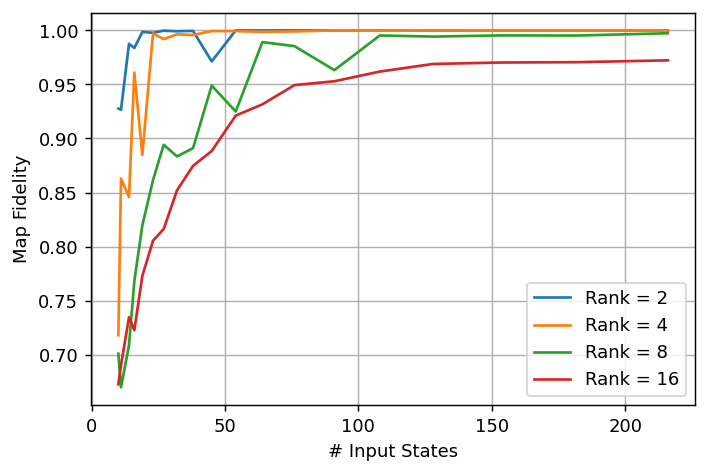

In [21]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(num_inputs_list, map_fidelity_list1)
plt.plot(num_inputs_list, map_fidelity_list2)
plt.plot(num_inputs_list, map_fidelity_list3)
plt.plot(num_inputs_list, map_fidelity_list4)
plt.xlabel("# Input States")
plt.ylabel("Map Fidelity")
plt.legend(["Rank = 2", "Rank = 4", "Rank = 8", "Rank = 16"])
plt.grid()
plt.show()

### Choi Kraus Mix
#### Choi Target, Kraus Model

In [48]:
n = 3
d = 2**n
rank = 2

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
choi_target = ChoiMap(d, rank)

X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X)
kraus_model = KrausMap(U, 0.1, d, rank)

state_target_list = [choi_target.apply_map(state_input) for state_input in state_input_list]

model5 = ModelQuantumMap(model = kraus_model,
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model5.train(num_iter = 2000, 
             use_adam = True)

0: fid: 0.481, c: 0.096
1: fid: 0.434, c: 0.098
2: fid: 0.439, c: 0.100
3: fid: 0.450, c: 0.101
4: fid: 0.564, c: 0.104
5: fid: 0.379, c: 0.107
6: fid: 0.683, c: 0.109
7: fid: 0.530, c: 0.111
8: fid: 0.423, c: 0.113
9: fid: 0.608, c: 0.115
10: fid: 0.498, c: 0.116
11: fid: 0.343, c: 0.117
12: fid: 0.711, c: 0.118
13: fid: 0.350, c: 0.119
14: fid: 0.583, c: 0.119
15: fid: 0.720, c: 0.119
16: fid: 0.647, c: 0.118
17: fid: 0.449, c: 0.117
18: fid: 0.267, c: 0.116
19: fid: 0.617, c: 0.115
20: fid: 0.598, c: 0.115
21: fid: 0.814, c: 0.114
22: fid: 0.487, c: 0.113
23: fid: 0.471, c: 0.112
24: fid: 0.374, c: 0.112
25: fid: 0.434, c: 0.112
26: fid: 0.494, c: 0.112
27: fid: 0.678, c: 0.111
28: fid: 0.601, c: 0.111
29: fid: 0.745, c: 0.110
30: fid: 0.439, c: 0.110
31: fid: 0.422, c: 0.110
32: fid: 0.662, c: 0.111
33: fid: 0.502, c: 0.111
34: fid: 0.516, c: 0.110
35: fid: 0.731, c: 0.109
36: fid: 0.484, c: 0.108
37: fid: 0.528, c: 0.106
38: fid: 0.545, c: 0.104
39: fid: 0.685, c: 0.102
40: fid: 0

320: fid: 0.999, c: 0.002
321: fid: 0.998, c: 0.002
322: fid: 0.999, c: 0.002
323: fid: 0.999, c: 0.002
324: fid: 0.999, c: 0.002
325: fid: 0.999, c: 0.002
326: fid: 0.999, c: 0.002
327: fid: 0.999, c: 0.002
328: fid: 0.999, c: 0.002
329: fid: 0.998, c: 0.002
330: fid: 0.998, c: 0.002
331: fid: 1.000, c: 0.002
332: fid: 0.999, c: 0.002
333: fid: 0.999, c: 0.002
334: fid: 0.999, c: 0.002
335: fid: 0.999, c: 0.002
336: fid: 0.999, c: 0.002
337: fid: 0.999, c: 0.002
338: fid: 0.999, c: 0.002
339: fid: 0.999, c: 0.002
340: fid: 0.999, c: 0.002
341: fid: 0.999, c: 0.002
342: fid: 0.998, c: 0.002
343: fid: 0.999, c: 0.002
344: fid: 0.999, c: 0.002
345: fid: 0.999, c: 0.002
346: fid: 0.999, c: 0.002
347: fid: 0.999, c: 0.002
348: fid: 0.999, c: 0.002
349: fid: 0.999, c: 0.002
350: fid: 0.999, c: 0.002
351: fid: 0.998, c: 0.002
352: fid: 0.999, c: 0.002
353: fid: 0.999, c: 0.002
354: fid: 0.999, c: 0.002
355: fid: 0.999, c: 0.002
356: fid: 0.999, c: 0.002
357: fid: 0.999, c: 0.002
358: fid: 0.

638: fid: 1.000, c: 0.001
639: fid: 1.000, c: 0.001
640: fid: 1.000, c: 0.001
641: fid: 1.000, c: 0.001
642: fid: 1.000, c: 0.001
643: fid: 1.000, c: 0.001
644: fid: 1.000, c: 0.001
645: fid: 1.000, c: 0.001
646: fid: 1.000, c: 0.001
647: fid: 1.000, c: 0.001
648: fid: 1.000, c: 0.001
649: fid: 1.000, c: 0.001
650: fid: 1.000, c: 0.001
651: fid: 1.000, c: 0.001
652: fid: 1.000, c: 0.001
653: fid: 1.000, c: 0.001
654: fid: 1.000, c: 0.001
655: fid: 1.000, c: 0.001
656: fid: 1.000, c: 0.001
657: fid: 1.000, c: 0.001
658: fid: 1.000, c: 0.001
659: fid: 1.000, c: 0.001
660: fid: 1.000, c: 0.001
661: fid: 1.000, c: 0.001
662: fid: 1.000, c: 0.001
663: fid: 1.000, c: 0.001
664: fid: 1.000, c: 0.001
665: fid: 1.000, c: 0.001
666: fid: 1.000, c: 0.001
667: fid: 1.000, c: 0.001
668: fid: 1.000, c: 0.001
669: fid: 1.000, c: 0.001
670: fid: 1.000, c: 0.001
671: fid: 1.000, c: 0.001
672: fid: 1.000, c: 0.001
673: fid: 1.000, c: 0.001
674: fid: 1.000, c: 0.001
675: fid: 1.000, c: 0.001
676: fid: 1.

955: fid: 1.000, c: 0.000
956: fid: 1.000, c: 0.000
957: fid: 1.000, c: 0.000
958: fid: 1.000, c: 0.000
959: fid: 1.000, c: 0.000
960: fid: 1.000, c: 0.000
961: fid: 1.000, c: 0.000
962: fid: 1.000, c: 0.000
963: fid: 1.000, c: 0.000
964: fid: 1.000, c: 0.000
965: fid: 1.000, c: 0.000
966: fid: 1.000, c: 0.000
967: fid: 1.000, c: 0.000
968: fid: 1.000, c: 0.000
969: fid: 1.000, c: 0.000
970: fid: 1.000, c: 0.000
971: fid: 1.000, c: 0.000
972: fid: 1.000, c: 0.000
973: fid: 1.000, c: 0.000
974: fid: 1.000, c: 0.000
975: fid: 1.000, c: 0.000
976: fid: 1.000, c: 0.000
977: fid: 1.000, c: 0.000
978: fid: 1.000, c: 0.000
979: fid: 1.000, c: 0.000
980: fid: 1.000, c: 0.000
981: fid: 1.000, c: 0.000
982: fid: 1.000, c: 0.000
983: fid: 1.000, c: 0.000
984: fid: 1.000, c: 0.000
985: fid: 1.000, c: 0.000
986: fid: 1.000, c: 0.000
987: fid: 1.000, c: 0.000
988: fid: 1.000, c: 0.000
989: fid: 1.000, c: 0.000
990: fid: 1.000, c: 0.000
991: fid: 1.000, c: 0.000
992: fid: 1.000, c: 0.000
993: fid: 1.

1263: fid: 1.000, c: 0.000
1264: fid: 1.000, c: 0.000
1265: fid: 1.000, c: 0.000
1266: fid: 1.000, c: 0.000
1267: fid: 1.000, c: 0.000
1268: fid: 1.000, c: 0.000
1269: fid: 1.000, c: 0.000
1270: fid: 1.000, c: 0.000
1271: fid: 1.000, c: 0.000
1272: fid: 1.000, c: 0.000
1273: fid: 1.000, c: 0.000
1274: fid: 1.000, c: 0.000
1275: fid: 1.000, c: 0.000
1276: fid: 1.000, c: 0.000
1277: fid: 1.000, c: 0.000
1278: fid: 1.000, c: 0.000
1279: fid: 1.000, c: 0.000
1280: fid: 1.000, c: 0.000
1281: fid: 1.000, c: 0.000
1282: fid: 1.000, c: 0.000
1283: fid: 1.000, c: 0.000
1284: fid: 1.000, c: 0.000
1285: fid: 1.000, c: 0.000
1286: fid: 1.000, c: 0.000
1287: fid: 1.000, c: 0.000
1288: fid: 1.000, c: 0.000
1289: fid: 1.000, c: 0.000
1290: fid: 1.000, c: 0.000
1291: fid: 1.000, c: 0.000
1292: fid: 1.000, c: 0.000
1293: fid: 1.000, c: 0.000
1294: fid: 1.000, c: 0.000
1295: fid: 1.000, c: 0.000
1296: fid: 1.000, c: 0.000
1297: fid: 1.000, c: 0.000
1298: fid: 1.000, c: 0.000
1299: fid: 1.000, c: 0.000
1

1567: fid: 1.000, c: 0.000
1568: fid: 1.000, c: 0.000
1569: fid: 1.000, c: 0.000
1570: fid: 1.000, c: 0.000
1571: fid: 1.000, c: 0.000
1572: fid: 1.000, c: 0.000
1573: fid: 1.000, c: 0.000
1574: fid: 1.000, c: 0.000
1575: fid: 1.000, c: 0.000
1576: fid: 1.000, c: 0.000
1577: fid: 1.000, c: 0.000
1578: fid: 1.000, c: 0.000
1579: fid: 1.000, c: 0.000
1580: fid: 1.000, c: 0.000
1581: fid: 1.000, c: 0.000
1582: fid: 1.000, c: 0.000
1583: fid: 1.000, c: 0.000
1584: fid: 1.000, c: 0.000
1585: fid: 1.000, c: 0.000
1586: fid: 1.000, c: 0.000
1587: fid: 1.000, c: 0.000
1588: fid: 1.000, c: 0.000
1589: fid: 1.000, c: 0.000
1590: fid: 1.000, c: 0.000
1591: fid: 1.000, c: 0.000
1592: fid: 1.000, c: 0.000
1593: fid: 1.000, c: 0.000
1594: fid: 1.000, c: 0.000
1595: fid: 1.000, c: 0.000
1596: fid: 1.000, c: 0.000
1597: fid: 1.000, c: 0.000
1598: fid: 1.000, c: 0.000
1599: fid: 1.000, c: 0.000
1600: fid: 1.000, c: 0.000
1601: fid: 1.000, c: 0.000
1602: fid: 1.000, c: 0.000
1603: fid: 1.000, c: 0.000
1

1873: fid: 1.000, c: 0.000
1874: fid: 1.000, c: 0.000
1875: fid: 1.000, c: 0.000
1876: fid: 1.000, c: 0.000
1877: fid: 1.000, c: 0.000
1878: fid: 1.000, c: 0.000
1879: fid: 1.000, c: 0.000
1880: fid: 1.000, c: 0.000
1881: fid: 1.000, c: 0.000
1882: fid: 1.000, c: 0.000
1883: fid: 1.000, c: 0.000
1884: fid: 1.000, c: 0.000
1885: fid: 1.000, c: 0.000
1886: fid: 1.000, c: 0.000
1887: fid: 1.000, c: 0.000
1888: fid: 1.000, c: 0.000
1889: fid: 1.000, c: 0.000
1890: fid: 1.000, c: 0.000
1891: fid: 1.000, c: 0.000
1892: fid: 1.000, c: 0.000
1893: fid: 1.000, c: 0.000
1894: fid: 1.000, c: 0.000
1895: fid: 1.000, c: 0.000
1896: fid: 1.000, c: 0.000
1897: fid: 1.000, c: 0.000
1898: fid: 1.000, c: 0.000
1899: fid: 1.000, c: 0.000
1900: fid: 1.000, c: 0.000
1901: fid: 1.000, c: 0.000
1902: fid: 1.000, c: 0.000
1903: fid: 1.000, c: 0.000
1904: fid: 1.000, c: 0.000
1905: fid: 1.000, c: 0.000
1906: fid: 1.000, c: 0.000
1907: fid: 1.000, c: 0.000
1908: fid: 1.000, c: 0.000
1909: fid: 1.000, c: 0.000
1

#### Kraus Target, Choi Model

In [49]:
n = 3
d = 2**n
rank = 2

state_input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]

np.random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X)
kraus_target = KrausMap(U, 0.5, d, rank)
choi_model = ChoiMap(d, rank+1)

state_target_list = [kraus_target.apply_map(state_input) for state_input in state_input_list]

model6 = ModelQuantumMap(model = choi_model,
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model6.train(num_iter = 2000, 
             use_adam = True)

0: fid: 0.570, c: 0.000
1: fid: 0.473, c: 0.000
2: fid: 0.546, c: 0.000
3: fid: 0.423, c: 0.000
4: fid: 0.576, c: 0.000
5: fid: 0.439, c: 0.000
6: fid: 0.436, c: 0.000
7: fid: 0.505, c: 0.000
8: fid: 0.387, c: 0.000
9: fid: 0.535, c: 0.000
10: fid: 0.404, c: 0.000
11: fid: 0.407, c: 0.000
12: fid: 0.518, c: 0.000
13: fid: 0.486, c: 0.000
14: fid: 0.541, c: 0.000
15: fid: 0.617, c: 0.000
16: fid: 0.557, c: 0.000
17: fid: 0.595, c: 0.000
18: fid: 0.611, c: 0.000
19: fid: 0.567, c: 0.000
20: fid: 0.489, c: 0.000
21: fid: 0.692, c: 0.000
22: fid: 0.554, c: 0.000
23: fid: 0.508, c: 0.000
24: fid: 0.609, c: 0.000
25: fid: 0.638, c: 0.000
26: fid: 0.561, c: 0.000
27: fid: 0.734, c: 0.000
28: fid: 0.630, c: 0.000
29: fid: 0.554, c: 0.000
30: fid: 0.523, c: 0.000
31: fid: 0.673, c: 0.000
32: fid: 0.554, c: 0.000
33: fid: 0.619, c: 0.000
34: fid: 0.592, c: 0.000
35: fid: 0.551, c: 0.000
36: fid: 0.727, c: 0.000
37: fid: 0.610, c: 0.000
38: fid: 0.600, c: 0.000
39: fid: 0.601, c: 0.000
40: fid: 0

320: fid: 0.999, c: 0.000
321: fid: 0.999, c: 0.000
322: fid: 0.999, c: 0.000
323: fid: 0.999, c: 0.000
324: fid: 0.999, c: 0.000
325: fid: 0.999, c: 0.000
326: fid: 0.999, c: 0.000
327: fid: 0.999, c: 0.000
328: fid: 0.999, c: 0.000
329: fid: 1.000, c: 0.000
330: fid: 0.999, c: 0.000
331: fid: 0.999, c: 0.000
332: fid: 0.999, c: 0.000
333: fid: 0.999, c: 0.000
334: fid: 0.999, c: 0.000
335: fid: 0.999, c: 0.000
336: fid: 0.999, c: 0.000
337: fid: 0.999, c: 0.000
338: fid: 0.999, c: 0.000
339: fid: 0.999, c: 0.000
340: fid: 0.999, c: 0.000
341: fid: 0.999, c: 0.000
342: fid: 0.999, c: 0.000
343: fid: 0.999, c: 0.000
344: fid: 0.999, c: 0.000
345: fid: 0.999, c: 0.000
346: fid: 0.999, c: 0.000
347: fid: 0.999, c: 0.000
348: fid: 1.000, c: 0.000
349: fid: 0.999, c: 0.000
350: fid: 0.999, c: 0.000
351: fid: 1.000, c: 0.000
352: fid: 0.999, c: 0.000
353: fid: 1.000, c: 0.000
354: fid: 0.999, c: 0.000
355: fid: 1.000, c: 0.000
356: fid: 1.000, c: 0.000
357: fid: 1.000, c: 0.000
358: fid: 1.

636: fid: 1.000, c: 0.000
637: fid: 1.000, c: 0.000
638: fid: 1.000, c: 0.000
639: fid: 1.000, c: 0.000
640: fid: 1.000, c: 0.000
641: fid: 1.000, c: 0.000
642: fid: 1.000, c: 0.000
643: fid: 1.000, c: 0.000
644: fid: 1.000, c: 0.000
645: fid: 1.000, c: 0.000
646: fid: 1.000, c: 0.000
647: fid: 1.000, c: 0.000
648: fid: 1.000, c: 0.000
649: fid: 1.000, c: 0.000
650: fid: 1.000, c: 0.000
651: fid: 1.000, c: 0.000
652: fid: 1.000, c: 0.000
653: fid: 1.000, c: 0.000
654: fid: 1.000, c: 0.000
655: fid: 1.000, c: 0.000
656: fid: 1.000, c: 0.000
657: fid: 1.000, c: 0.000
658: fid: 1.000, c: 0.000
659: fid: 1.000, c: 0.000
660: fid: 1.000, c: 0.000
661: fid: 1.000, c: 0.000
662: fid: 1.000, c: 0.000
663: fid: 1.000, c: 0.000
664: fid: 1.000, c: 0.000
665: fid: 1.000, c: 0.000
666: fid: 1.000, c: 0.000
667: fid: 1.000, c: 0.000
668: fid: 1.000, c: 0.000
669: fid: 1.000, c: 0.000
670: fid: 1.000, c: 0.000
671: fid: 1.000, c: 0.000
672: fid: 1.000, c: 0.000
673: fid: 1.000, c: 0.000
674: fid: 1.

952: fid: 1.000, c: 0.000
953: fid: 1.000, c: 0.000
954: fid: 1.000, c: 0.000
955: fid: 1.000, c: 0.000
956: fid: 1.000, c: 0.000
957: fid: 1.000, c: 0.000
958: fid: 1.000, c: 0.000
959: fid: 1.000, c: 0.000
960: fid: 1.000, c: 0.000
961: fid: 1.000, c: 0.000
962: fid: 1.000, c: 0.000
963: fid: 1.000, c: 0.000
964: fid: 1.000, c: 0.000
965: fid: 1.000, c: 0.000
966: fid: 1.000, c: 0.000
967: fid: 1.000, c: 0.000
968: fid: 1.000, c: 0.000
969: fid: 1.000, c: 0.000
970: fid: 1.000, c: 0.000
971: fid: 1.000, c: 0.000
972: fid: 1.000, c: 0.000
973: fid: 1.000, c: 0.000
974: fid: 1.000, c: 0.000
975: fid: 1.000, c: 0.000
976: fid: 1.000, c: 0.000
977: fid: 1.000, c: 0.000
978: fid: 1.000, c: 0.000
979: fid: 1.000, c: 0.000
980: fid: 1.000, c: 0.000
981: fid: 1.000, c: 0.000
982: fid: 1.000, c: 0.000
983: fid: 1.000, c: 0.000
984: fid: 1.000, c: 0.000
985: fid: 1.000, c: 0.000
986: fid: 1.000, c: 0.000
987: fid: 1.000, c: 0.000
988: fid: 1.000, c: 0.000
989: fid: 1.000, c: 0.000
990: fid: 1.

1258: fid: 1.000, c: 0.000
1259: fid: 1.000, c: 0.000
1260: fid: 1.000, c: 0.000
1261: fid: 1.000, c: 0.000
1262: fid: 1.000, c: 0.000
1263: fid: 1.000, c: 0.000
1264: fid: 1.000, c: 0.000
1265: fid: 1.000, c: 0.000
1266: fid: 1.000, c: 0.000
1267: fid: 1.000, c: 0.000
1268: fid: 1.000, c: 0.000
1269: fid: 1.000, c: 0.000
1270: fid: 1.000, c: 0.000
1271: fid: 1.000, c: 0.000
1272: fid: 1.000, c: 0.000
1273: fid: 1.000, c: 0.000
1274: fid: 1.000, c: 0.000
1275: fid: 1.000, c: 0.000
1276: fid: 1.000, c: 0.000
1277: fid: 1.000, c: 0.000
1278: fid: 1.000, c: 0.000
1279: fid: 1.000, c: 0.000
1280: fid: 1.000, c: 0.000
1281: fid: 1.000, c: 0.000
1282: fid: 1.000, c: 0.000
1283: fid: 1.000, c: 0.000
1284: fid: 1.000, c: 0.000
1285: fid: 1.000, c: 0.000
1286: fid: 1.000, c: 0.000
1287: fid: 1.000, c: 0.000
1288: fid: 1.000, c: 0.000
1289: fid: 1.000, c: 0.000
1290: fid: 1.000, c: 0.000
1291: fid: 1.000, c: 0.000
1292: fid: 1.000, c: 0.000
1293: fid: 1.000, c: 0.000
1294: fid: 1.000, c: 0.000
1

1562: fid: 1.000, c: 0.000
1563: fid: 1.000, c: 0.000
1564: fid: 1.000, c: 0.000
1565: fid: 1.000, c: 0.000
1566: fid: 1.000, c: 0.000
1567: fid: 1.000, c: 0.000
1568: fid: 1.000, c: 0.000
1569: fid: 1.000, c: 0.000
1570: fid: 1.000, c: 0.000
1571: fid: 1.000, c: 0.000
1572: fid: 1.000, c: 0.000
1573: fid: 1.000, c: 0.000
1574: fid: 1.000, c: 0.000
1575: fid: 1.000, c: 0.000
1576: fid: 1.000, c: 0.000
1577: fid: 1.000, c: 0.000
1578: fid: 1.000, c: 0.000
1579: fid: 1.000, c: 0.000
1580: fid: 1.000, c: 0.000
1581: fid: 1.000, c: 0.000
1582: fid: 1.000, c: 0.000
1583: fid: 1.000, c: 0.000
1584: fid: 1.000, c: 0.000
1585: fid: 1.000, c: 0.000
1586: fid: 1.000, c: 0.000
1587: fid: 1.000, c: 0.000
1588: fid: 1.000, c: 0.000
1589: fid: 1.000, c: 0.000
1590: fid: 1.000, c: 0.000
1591: fid: 1.000, c: 0.000
1592: fid: 1.000, c: 0.000
1593: fid: 1.000, c: 0.000
1594: fid: 1.000, c: 0.000
1595: fid: 1.000, c: 0.000
1596: fid: 1.000, c: 0.000
1597: fid: 1.000, c: 0.000
1598: fid: 1.000, c: 0.000
1

1866: fid: 1.000, c: 0.000
1867: fid: 1.000, c: 0.000
1868: fid: 1.000, c: 0.000
1869: fid: 1.000, c: 0.000
1870: fid: 1.000, c: 0.000
1871: fid: 1.000, c: 0.000
1872: fid: 1.000, c: 0.000
1873: fid: 1.000, c: 0.000
1874: fid: 1.000, c: 0.000
1875: fid: 1.000, c: 0.000
1876: fid: 1.000, c: 0.000
1877: fid: 1.000, c: 0.000
1878: fid: 1.000, c: 0.000
1879: fid: 1.000, c: 0.000
1880: fid: 1.000, c: 0.000
1881: fid: 1.000, c: 0.000
1882: fid: 1.000, c: 0.000
1883: fid: 1.000, c: 0.000
1884: fid: 1.000, c: 0.000
1885: fid: 1.000, c: 0.000
1886: fid: 1.000, c: 0.000
1887: fid: 1.000, c: 0.000
1888: fid: 1.000, c: 0.000
1889: fid: 1.000, c: 0.000
1890: fid: 1.000, c: 0.000
1891: fid: 1.000, c: 0.000
1892: fid: 1.000, c: 0.000
1893: fid: 1.000, c: 0.000
1894: fid: 1.000, c: 0.000
1895: fid: 1.000, c: 0.000
1896: fid: 1.000, c: 0.000
1897: fid: 1.000, c: 0.000
1898: fid: 1.000, c: 0.000
1899: fid: 1.000, c: 0.000
1900: fid: 1.000, c: 0.000
1901: fid: 1.000, c: 0.000
1902: fid: 1.000, c: 0.000
1

## Pauli Expectation Value

In [ ]:
n = 3
d = 2**n

np.random.seed(42)
X, _, _ = generate_ginibre(d, d)
U = generate_unitary(X)

kraus_target = KrausMap(U, c = 0.7, d = d, rank = 2)
choi_target = kraus_to_choi(kraus_target)

num_samples = 1000
input_list = []
target_list = []
for i in range(num_samples):
    config = np.random.randint(6, size=n)
    state = prepare_input(config)
    config = np.random.randint(4, size=n)
    observable = pauli_observable(config)
    
    E = expectation_value(state, observable, kraus_target)
    
    input_list.append([state, observable])
    target_list.append(E)

kraus_model = KrausMap(U, c = 0.1, d = d, rank = 2)

model = ModelQuantumMap(model = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.05, 
                        h = 1e-4)

model.train(num_iter = 1000, 
            use_adam = True,
            N = 50,
            choi_target=choi_target)

0: fid: 0.396, c: 0.096
1: fid: 0.392, c: 0.092
2: fid: 0.388, c: 0.088
3: fid: 0.385, c: 0.086
4: fid: 0.386, c: 0.086
5: fid: 0.386, c: 0.086
6: fid: 0.386, c: 0.086
7: fid: 0.385, c: 0.086
8: fid: 0.385, c: 0.086
9: fid: 0.384, c: 0.086
10: fid: 0.385, c: 0.087
11: fid: 0.384, c: 0.087
12: fid: 0.382, c: 0.086
13: fid: 0.382, c: 0.086
14: fid: 0.380, c: 0.085
15: fid: 0.379, c: 0.085
16: fid: 0.379, c: 0.085
17: fid: 0.378, c: 0.085
18: fid: 0.376, c: 0.084
19: fid: 0.376, c: 0.085
20: fid: 0.378, c: 0.086
21: fid: 0.379, c: 0.088
22: fid: 0.380, c: 0.089
23: fid: 0.382, c: 0.091
24: fid: 0.383, c: 0.092
25: fid: 0.384, c: 0.093
26: fid: 0.385, c: 0.095
27: fid: 0.385, c: 0.095
28: fid: 0.386, c: 0.096
29: fid: 0.387, c: 0.097
30: fid: 0.388, c: 0.098
31: fid: 0.389, c: 0.099
32: fid: 0.390, c: 0.101
33: fid: 0.390, c: 0.101
34: fid: 0.390, c: 0.101
35: fid: 0.391, c: 0.102
36: fid: 0.392, c: 0.103
37: fid: 0.393, c: 0.105
38: fid: 0.395, c: 0.106
39: fid: 0.397, c: 0.108
40: fid: 0

320: fid: 0.475, c: 0.170
321: fid: 0.475, c: 0.171
322: fid: 0.476, c: 0.171
323: fid: 0.476, c: 0.172
324: fid: 0.477, c: 0.174
325: fid: 0.478, c: 0.174
326: fid: 0.479, c: 0.175
327: fid: 0.479, c: 0.176
328: fid: 0.480, c: 0.177
329: fid: 0.480, c: 0.177
330: fid: 0.479, c: 0.177
331: fid: 0.478, c: 0.175
332: fid: 0.476, c: 0.173
333: fid: 0.475, c: 0.172
334: fid: 0.473, c: 0.170
335: fid: 0.472, c: 0.169
336: fid: 0.471, c: 0.168
337: fid: 0.471, c: 0.168
338: fid: 0.471, c: 0.168
339: fid: 0.471, c: 0.168
340: fid: 0.471, c: 0.168
341: fid: 0.472, c: 0.169
342: fid: 0.472, c: 0.169
343: fid: 0.472, c: 0.169
344: fid: 0.472, c: 0.169
345: fid: 0.473, c: 0.171
346: fid: 0.474, c: 0.172
347: fid: 0.476, c: 0.175
348: fid: 0.478, c: 0.177
349: fid: 0.479, c: 0.178
350: fid: 0.480, c: 0.180
351: fid: 0.480, c: 0.180
352: fid: 0.481, c: 0.181
353: fid: 0.481, c: 0.181
354: fid: 0.481, c: 0.181
355: fid: 0.482, c: 0.182
356: fid: 0.482, c: 0.183
357: fid: 0.483, c: 0.184
358: fid: 0.

## Real Hardware

### Two Qubits, Santiago

In [2]:
input_list, target_list = pickle.load(open("..\..\data\single.p", "rb"))

n = 2
d = 2**n
rank = 3

circuit = qk.QuantumCircuit(2)
circuit.h(0)
circuit.h(1)
circuit.cnot(0,1)

U = Operator(circuit).data

kraus_model = KrausMap(U, 0.5, d, rank)

model1 = ModelQuantumMap(q_map = kraus_model,
                         cost = state_density_loss,
                         input_list = input_list,
                         target_list = target_list,
                         lr = 0.05, 
                         h = 1e-4)

model1.train(num_iter = 1000, 
             use_adam = True)

TypeError: __init__() got an unexpected keyword argument 'map'

In [11]:
state_input_list, state_target_list = pickle.load(open("..\..\data\double.p", "rb"))

n = 2
d = 2**n
rank = 4

circuit = qk.QuantumCircuit(2)
circuit.h(0)
circuit.h(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.h(1)
circuit.cnot(0,1)

U = Operator(circuit).data

kraus_model = KrausMap(U, 0.5, d, rank)

model2 = ModelQuantumMap(model = kraus_model,
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.05, 
                         h = 1e-4)

model2.train(num_iter = 1000, 
             use_adam = True)

0: fid: 0.897, c: 0.512
1: fid: 0.927, c: 0.525
2: fid: 0.909, c: 0.536
3: fid: 0.910, c: 0.545
4: fid: 0.838, c: 0.556
5: fid: 0.942, c: 0.566
6: fid: 0.909, c: 0.577
7: fid: 0.910, c: 0.587
8: fid: 0.954, c: 0.596
9: fid: 0.946, c: 0.605
10: fid: 0.916, c: 0.613
11: fid: 0.889, c: 0.623
12: fid: 0.883, c: 0.632
13: fid: 0.889, c: 0.641
14: fid: 0.949, c: 0.649
15: fid: 0.909, c: 0.658
16: fid: 0.975, c: 0.666
17: fid: 0.968, c: 0.672
18: fid: 0.919, c: 0.680
19: fid: 0.954, c: 0.687
20: fid: 0.950, c: 0.694
21: fid: 0.948, c: 0.699
22: fid: 0.943, c: 0.705
23: fid: 0.957, c: 0.710
24: fid: 0.957, c: 0.714
25: fid: 0.956, c: 0.718
26: fid: 0.957, c: 0.722
27: fid: 0.958, c: 0.725
28: fid: 0.936, c: 0.729
29: fid: 0.938, c: 0.732
30: fid: 0.929, c: 0.736
31: fid: 0.945, c: 0.740
32: fid: 0.975, c: 0.744
33: fid: 0.967, c: 0.747
34: fid: 0.960, c: 0.749
35: fid: 0.947, c: 0.752
36: fid: 0.949, c: 0.754
37: fid: 0.965, c: 0.756
38: fid: 0.951, c: 0.758
39: fid: 0.961, c: 0.760
40: fid: 0

322: fid: 0.994, c: 0.607
323: fid: 0.994, c: 0.605
324: fid: 0.986, c: 0.603
325: fid: 0.990, c: 0.602
326: fid: 0.987, c: 0.600
327: fid: 0.977, c: 0.599
328: fid: 0.990, c: 0.598
329: fid: 0.994, c: 0.598
330: fid: 0.996, c: 0.596
331: fid: 0.990, c: 0.595
332: fid: 0.986, c: 0.593
333: fid: 0.984, c: 0.592
334: fid: 0.982, c: 0.591
335: fid: 0.993, c: 0.590
336: fid: 0.993, c: 0.589
337: fid: 0.990, c: 0.588
338: fid: 0.988, c: 0.588
339: fid: 0.981, c: 0.588
340: fid: 0.991, c: 0.588
341: fid: 0.992, c: 0.587
342: fid: 0.985, c: 0.587
343: fid: 0.982, c: 0.586
344: fid: 0.993, c: 0.586
345: fid: 0.995, c: 0.586
346: fid: 0.978, c: 0.587
347: fid: 0.980, c: 0.589
348: fid: 0.995, c: 0.591
349: fid: 0.989, c: 0.593
350: fid: 0.993, c: 0.594
351: fid: 0.992, c: 0.595
352: fid: 0.993, c: 0.596
353: fid: 0.983, c: 0.596
354: fid: 0.986, c: 0.596
355: fid: 0.990, c: 0.596
356: fid: 0.994, c: 0.597
357: fid: 0.988, c: 0.597
358: fid: 0.996, c: 0.598
359: fid: 0.994, c: 0.598
360: fid: 0.

643: fid: 0.986, c: 0.474
644: fid: 0.993, c: 0.474
645: fid: 0.986, c: 0.473
646: fid: 0.990, c: 0.473
647: fid: 0.989, c: 0.472
648: fid: 0.995, c: 0.473
649: fid: 0.993, c: 0.473
650: fid: 0.997, c: 0.473
651: fid: 0.993, c: 0.473
652: fid: 0.995, c: 0.473
653: fid: 0.993, c: 0.473
654: fid: 0.997, c: 0.473
655: fid: 0.991, c: 0.473
656: fid: 0.992, c: 0.473
657: fid: 0.989, c: 0.474
658: fid: 0.995, c: 0.476
659: fid: 0.997, c: 0.477
660: fid: 0.995, c: 0.477
661: fid: 0.998, c: 0.477
662: fid: 0.997, c: 0.477
663: fid: 0.996, c: 0.478
664: fid: 0.990, c: 0.478
665: fid: 0.985, c: 0.478
666: fid: 0.981, c: 0.477
667: fid: 0.987, c: 0.477
668: fid: 0.988, c: 0.476
669: fid: 0.995, c: 0.476
670: fid: 0.990, c: 0.476
671: fid: 0.996, c: 0.476
672: fid: 0.992, c: 0.477
673: fid: 0.990, c: 0.477
674: fid: 0.989, c: 0.479
675: fid: 0.991, c: 0.480
676: fid: 0.993, c: 0.481
677: fid: 0.996, c: 0.483
678: fid: 0.987, c: 0.484
679: fid: 0.997, c: 0.485
680: fid: 0.997, c: 0.486
681: fid: 0.

In [41]:
np.random.seed(42)

state = generate_state(d,1)
state1 = model1.model.apply_map(model1.model.apply_map(state))
state2 = model2.model.apply_map(state)
print(state_fidelity(state1, state2))

state = generate_state(d,1)
state1 = model1.model.apply_map(model1.model.apply_map(state))
state2 = model2.model.apply_map(state)
print(state_fidelity(state1, state2))

state = generate_state(d,1)
state1 = model1.model.apply_map(model1.model.apply_map(state))
state2 = model2.model.apply_map(state)
print(state_fidelity(state1, state2))

state = generate_state(d,1)
state1 = model1.model.apply_map(model1.model.apply_map(state))
state2 = model2.model.apply_map(state)
print(state_fidelity(state1, state2))


0.966256988595146
0.9417531194722277
0.9808991874749217
0.9613363948206397


### Three Qubits, Santiago

In [12]:
state_input_list, state_target_list = pickle.load(open("..\..\data\single_three.p", "rb"))

n = 3
d = 2**n
rank = 5

circuit = qk.QuantumCircuit(3)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.cnot(0,1)
circuit.cnot(1,2)

U = Operator(circuit).data

kraus_model = KrausMap(U, 0.5, d, rank)

model3 = ModelQuantumMap(model = kraus_model,
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.02, 
                         h = 1e-4)

model3.train(num_iter = 2000, 
             use_adam = True)

0: fid: 0.819, c: 0.505
1: fid: 0.841, c: 0.510
2: fid: 0.866, c: 0.515
3: fid: 0.855, c: 0.520
4: fid: 0.836, c: 0.524
5: fid: 0.869, c: 0.529
6: fid: 0.840, c: 0.534
7: fid: 0.849, c: 0.539
8: fid: 0.901, c: 0.543
9: fid: 0.842, c: 0.548
10: fid: 0.886, c: 0.552
11: fid: 0.865, c: 0.557
12: fid: 0.839, c: 0.561
13: fid: 0.857, c: 0.566
14: fid: 0.894, c: 0.570
15: fid: 0.867, c: 0.574
16: fid: 0.870, c: 0.578
17: fid: 0.857, c: 0.583
18: fid: 0.863, c: 0.587
19: fid: 0.879, c: 0.592
20: fid: 0.871, c: 0.596
21: fid: 0.871, c: 0.601
22: fid: 0.930, c: 0.605
23: fid: 0.914, c: 0.609
24: fid: 0.873, c: 0.613
25: fid: 0.877, c: 0.617
26: fid: 0.878, c: 0.621
27: fid: 0.880, c: 0.625
28: fid: 0.862, c: 0.629
29: fid: 0.883, c: 0.633
30: fid: 0.943, c: 0.636
31: fid: 0.869, c: 0.640
32: fid: 0.892, c: 0.643
33: fid: 0.947, c: 0.647
34: fid: 0.926, c: 0.650
35: fid: 0.897, c: 0.654
36: fid: 0.901, c: 0.657
37: fid: 0.934, c: 0.660
38: fid: 0.896, c: 0.663
39: fid: 0.909, c: 0.667
40: fid: 0

320: fid: 0.974, c: 0.780
321: fid: 0.972, c: 0.780
322: fid: 0.972, c: 0.780
323: fid: 0.973, c: 0.780
324: fid: 0.972, c: 0.780
325: fid: 0.970, c: 0.779
326: fid: 0.979, c: 0.779
327: fid: 0.976, c: 0.779
328: fid: 0.966, c: 0.779
329: fid: 0.973, c: 0.780
330: fid: 0.969, c: 0.779
331: fid: 0.969, c: 0.779
332: fid: 0.968, c: 0.779
333: fid: 0.948, c: 0.779
334: fid: 0.980, c: 0.779
335: fid: 0.962, c: 0.779
336: fid: 0.969, c: 0.779
337: fid: 0.972, c: 0.779
338: fid: 0.971, c: 0.779
339: fid: 0.952, c: 0.779
340: fid: 0.969, c: 0.779
341: fid: 0.981, c: 0.779
342: fid: 0.977, c: 0.779
343: fid: 0.974, c: 0.779
344: fid: 0.973, c: 0.779
345: fid: 0.954, c: 0.778
346: fid: 0.976, c: 0.778
347: fid: 0.978, c: 0.778
348: fid: 0.974, c: 0.778
349: fid: 0.979, c: 0.777
350: fid: 0.968, c: 0.777
351: fid: 0.975, c: 0.776
352: fid: 0.960, c: 0.776
353: fid: 0.970, c: 0.775
354: fid: 0.970, c: 0.774
355: fid: 0.974, c: 0.774
356: fid: 0.975, c: 0.773
357: fid: 0.959, c: 0.773
358: fid: 0.

636: fid: 0.972, c: 0.716
637: fid: 0.986, c: 0.716
638: fid: 0.987, c: 0.715
639: fid: 0.985, c: 0.715
640: fid: 0.972, c: 0.714
641: fid: 0.973, c: 0.713
642: fid: 0.991, c: 0.713
643: fid: 0.983, c: 0.712
644: fid: 0.980, c: 0.712
645: fid: 0.978, c: 0.712
646: fid: 0.988, c: 0.711
647: fid: 0.977, c: 0.711
648: fid: 0.986, c: 0.710
649: fid: 0.983, c: 0.710
650: fid: 0.980, c: 0.709
651: fid: 0.974, c: 0.709
652: fid: 0.985, c: 0.709
653: fid: 0.987, c: 0.708
654: fid: 0.975, c: 0.707
655: fid: 0.988, c: 0.707
656: fid: 0.977, c: 0.706
657: fid: 0.973, c: 0.706
658: fid: 0.988, c: 0.706
659: fid: 0.988, c: 0.706
660: fid: 0.980, c: 0.706
661: fid: 0.988, c: 0.705
662: fid: 0.975, c: 0.705
663: fid: 0.972, c: 0.705
664: fid: 0.986, c: 0.704
665: fid: 0.988, c: 0.704
666: fid: 0.986, c: 0.704
667: fid: 0.980, c: 0.704
668: fid: 0.988, c: 0.704
669: fid: 0.978, c: 0.704
670: fid: 0.990, c: 0.703
671: fid: 0.988, c: 0.704
672: fid: 0.988, c: 0.703
673: fid: 0.977, c: 0.703
674: fid: 0.

953: fid: 0.986, c: 0.665
954: fid: 0.991, c: 0.665
955: fid: 0.971, c: 0.666
956: fid: 0.985, c: 0.666
957: fid: 0.989, c: 0.667
958: fid: 0.986, c: 0.667
959: fid: 0.987, c: 0.667
960: fid: 0.989, c: 0.668
961: fid: 0.989, c: 0.668
962: fid: 0.982, c: 0.668
963: fid: 0.984, c: 0.669
964: fid: 0.988, c: 0.669
965: fid: 0.982, c: 0.669
966: fid: 0.994, c: 0.669
967: fid: 0.987, c: 0.669
968: fid: 0.990, c: 0.670
969: fid: 0.994, c: 0.670
970: fid: 0.988, c: 0.670
971: fid: 0.986, c: 0.670
972: fid: 0.991, c: 0.670
973: fid: 0.991, c: 0.671
974: fid: 0.990, c: 0.671
975: fid: 0.984, c: 0.671
976: fid: 0.987, c: 0.671
977: fid: 0.990, c: 0.671
978: fid: 0.987, c: 0.672
979: fid: 0.990, c: 0.672
980: fid: 0.987, c: 0.672
981: fid: 0.977, c: 0.672
982: fid: 0.983, c: 0.671
983: fid: 0.987, c: 0.671
984: fid: 0.991, c: 0.671
985: fid: 0.978, c: 0.670
986: fid: 0.981, c: 0.670
987: fid: 0.992, c: 0.669
988: fid: 0.991, c: 0.669
989: fid: 0.977, c: 0.668
990: fid: 0.987, c: 0.668
991: fid: 0.

1260: fid: 0.993, c: 0.632
1261: fid: 0.988, c: 0.632
1262: fid: 0.986, c: 0.632
1263: fid: 0.986, c: 0.631
1264: fid: 0.988, c: 0.631
1265: fid: 0.988, c: 0.631
1266: fid: 0.987, c: 0.630
1267: fid: 0.993, c: 0.630
1268: fid: 0.984, c: 0.629
1269: fid: 0.989, c: 0.628
1270: fid: 0.989, c: 0.628
1271: fid: 0.986, c: 0.627
1272: fid: 0.988, c: 0.627
1273: fid: 0.986, c: 0.626
1274: fid: 0.993, c: 0.626
1275: fid: 0.990, c: 0.625
1276: fid: 0.990, c: 0.625
1277: fid: 0.986, c: 0.625
1278: fid: 0.995, c: 0.625
1279: fid: 0.992, c: 0.624
1280: fid: 0.986, c: 0.624
1281: fid: 0.987, c: 0.623
1282: fid: 0.985, c: 0.623
1283: fid: 0.988, c: 0.623
1284: fid: 0.989, c: 0.623
1285: fid: 0.989, c: 0.623
1286: fid: 0.993, c: 0.623
1287: fid: 0.987, c: 0.624
1288: fid: 0.988, c: 0.624
1289: fid: 0.988, c: 0.624
1290: fid: 0.995, c: 0.624
1291: fid: 0.990, c: 0.624
1292: fid: 0.990, c: 0.624
1293: fid: 0.981, c: 0.624
1294: fid: 0.989, c: 0.624
1295: fid: 0.987, c: 0.624
1296: fid: 0.992, c: 0.624
1

KeyboardInterrupt: 

In [ ]:
state_input_list, state_target_list = pickle.load(open("..\..\data\double_three.p", "rb"))

n = 3
d = 2**n
rank = 7

circuit = qk.QuantumCircuit(3)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.cnot(0,1)
circuit.cnot(1,2)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.cnot(0,1)
circuit.cnot(1,2)

U = Operator(circuit).data

kraus_model = KrausMap(U, 0.5, d, rank)

model4 = ModelQuantumMap(model = kraus_model,
                         state_input_list = state_input_list,
                         state_target_list = state_target_list,
                         lr = 0.02, 
                         h = 1e-4)

model4.train(num_iter = 2000, 
             use_adam = True)